### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

I have put lab1_train.csv and lab1_test.csv in root folder together with the notebook.

In [3]:
train_file_path = 'resources/lab1_train.csv'
test_file_path = 'resources/lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')
# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

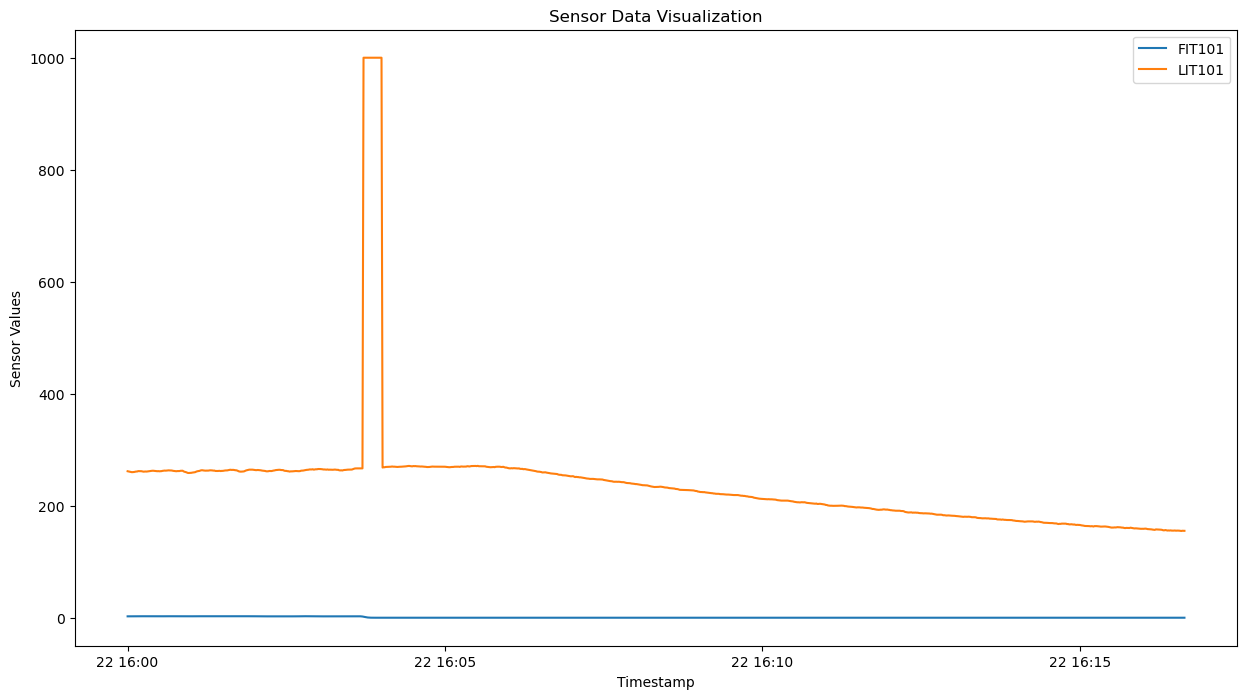

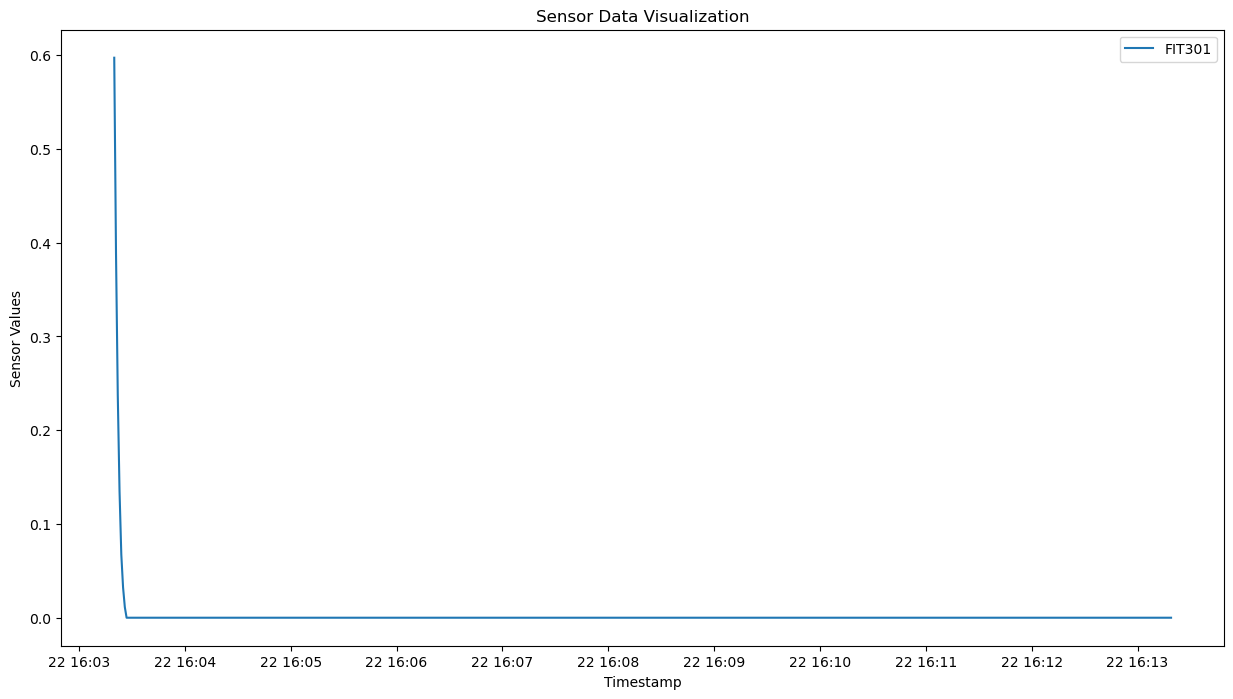

/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


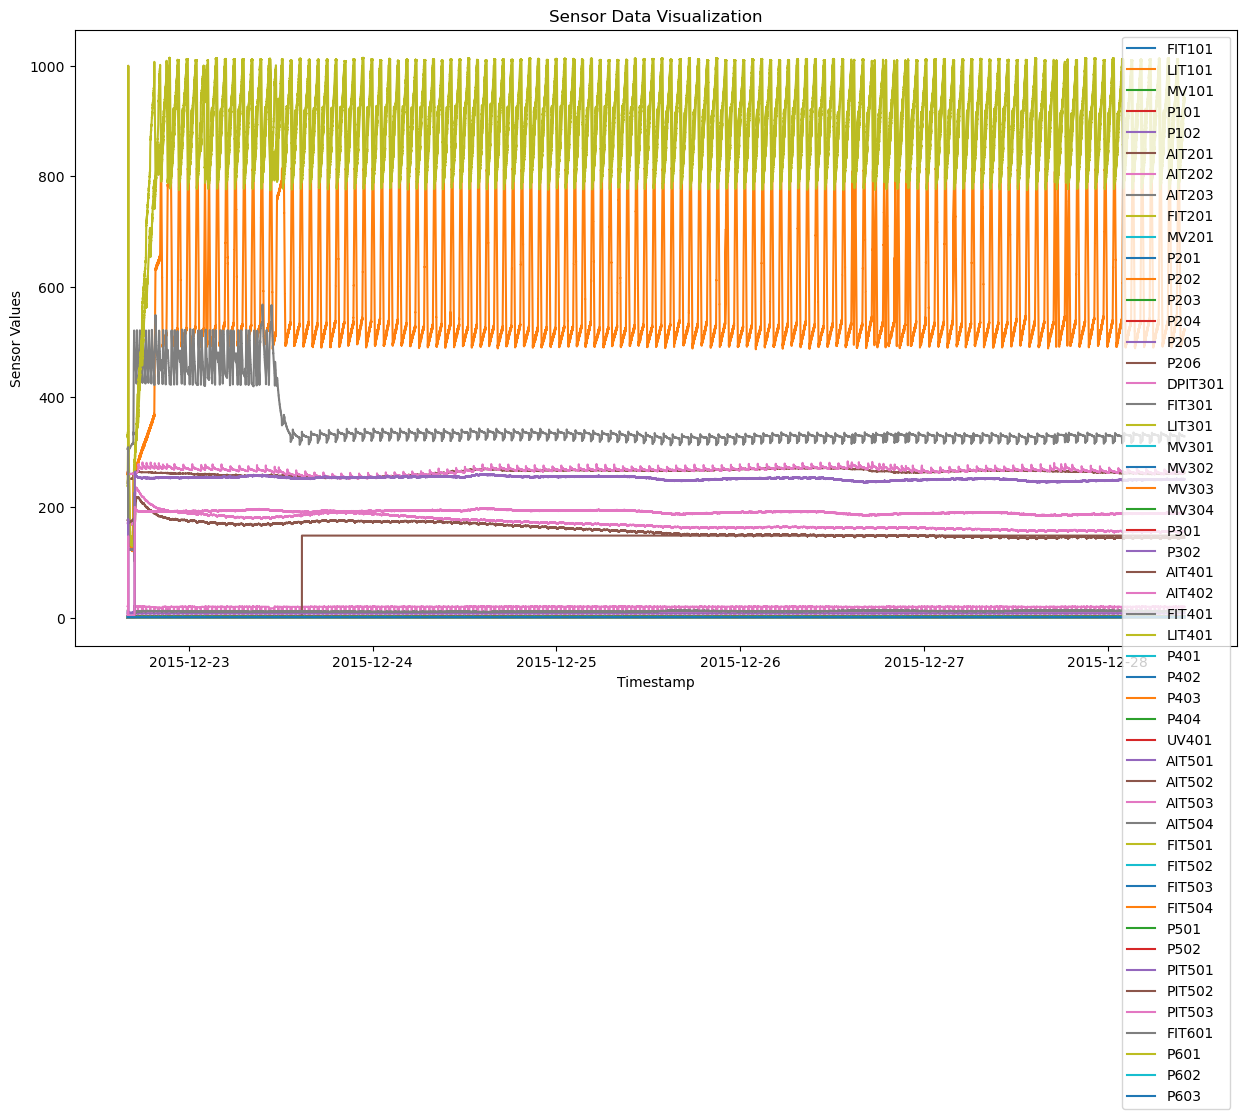

In [4]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)

---

## Familiarization (10 points)

Load the sensor data (train with training data, test with test data) into a Jupyter
Notebook and understand the data using visualizations. Answer the following questions:

    1. What types of signals are there?
    2. Are the signals correlated? Do they show cyclic behavior?
Visualize these types and the presence or absence of correlation.

In the data provided the signals provide many different types of signals, these include: constant values, oscillating regular patterns,...

The graphs below show some of these signals. In the first graph we can see 3 different sensors with similar behaviour in the signals they read. If we were to describe these signals they all have a significant drop right at the beginning after which they all start rising over time to a specific point (different for each signal) and then all three start following a regular oscillating behaviour. Although the oscillation of each signal have a different shape, the periods are mostly equal with some exceptions that occur (possible anomalies).

In the second graph we see similar behaviour from 8 additional sensors with a drop at the start, a rise back up and then either remaining at a constant or oscillation slightly around a mean. Where these 8 signals differ from the 3 previous ones is that the rise at the beginning seems instantaneous and secondly, if there are fluctuations later in time, they don't seem to follow a regular period with each other (we'll see this later more in-depth).

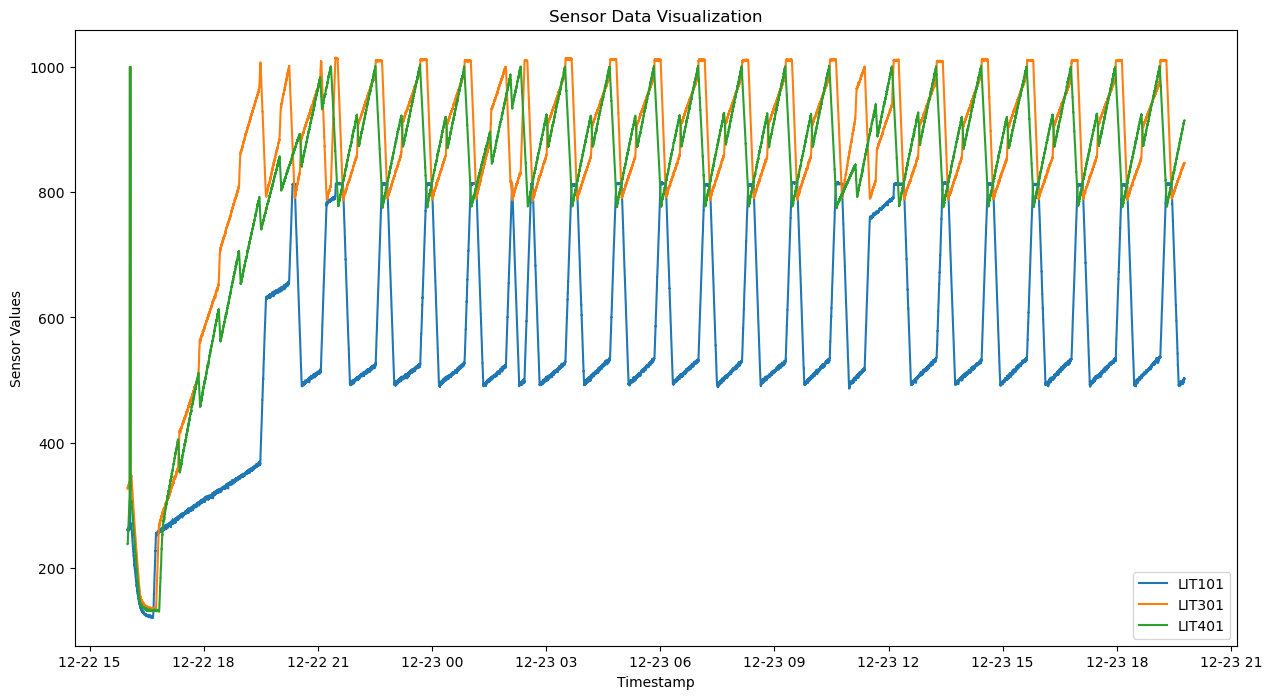

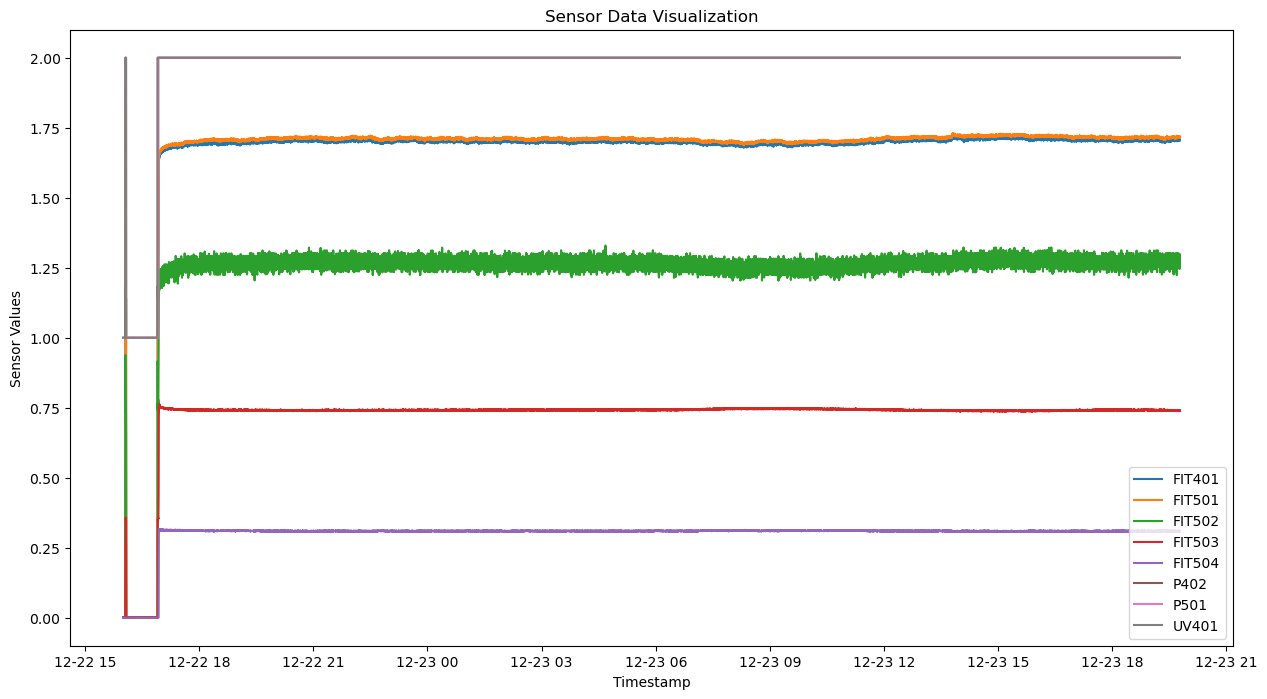

In [5]:
# oscillating behaviour with occasional change in behaviour, these signals are very similar but shifted (prime suspect to use DTW on)
visualize_sensor_data(train_data, window=(0, 100000), sensors=['LIT101', 'LIT301', 'LIT401'])
# similar behavioural patterns with drop then constant value (some with minor oscillations but mean value is constant)
visualize_sensor_data(train_data, window=(0, 100000), sensors=['FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P402', 'P501', 'UV401'])


When we look at the heatmap provided in the file train_corr_plot.ipynb (provided for us in the assignment), we can see that the correlation between these values between each other is quite high (the bright 'square' of correlations in the lower right corner).

Now let's take 2 specific signals from the data, namely 'FIT401' and 'FIT501'. These two sensors seem to exhibit almost identical behaviour, so I take a closer look at it in the second graph in which we can see that indeed the fluctuations seem to occur at similar times but the data is shifted.

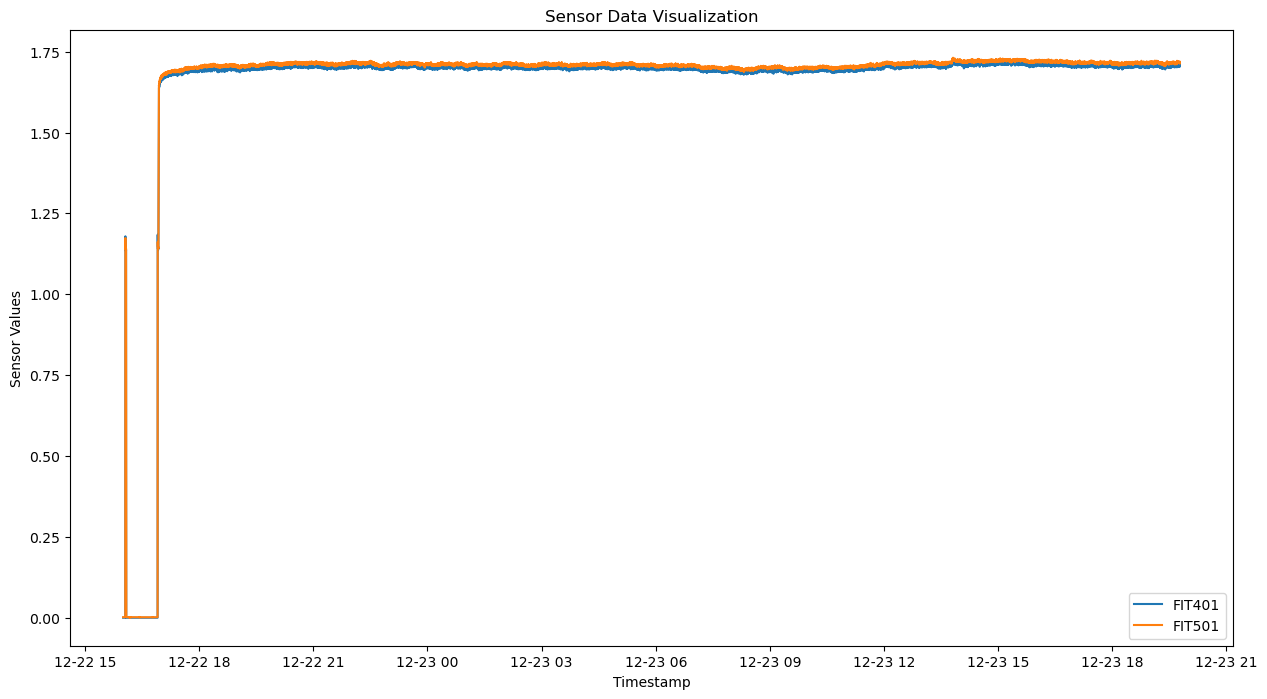

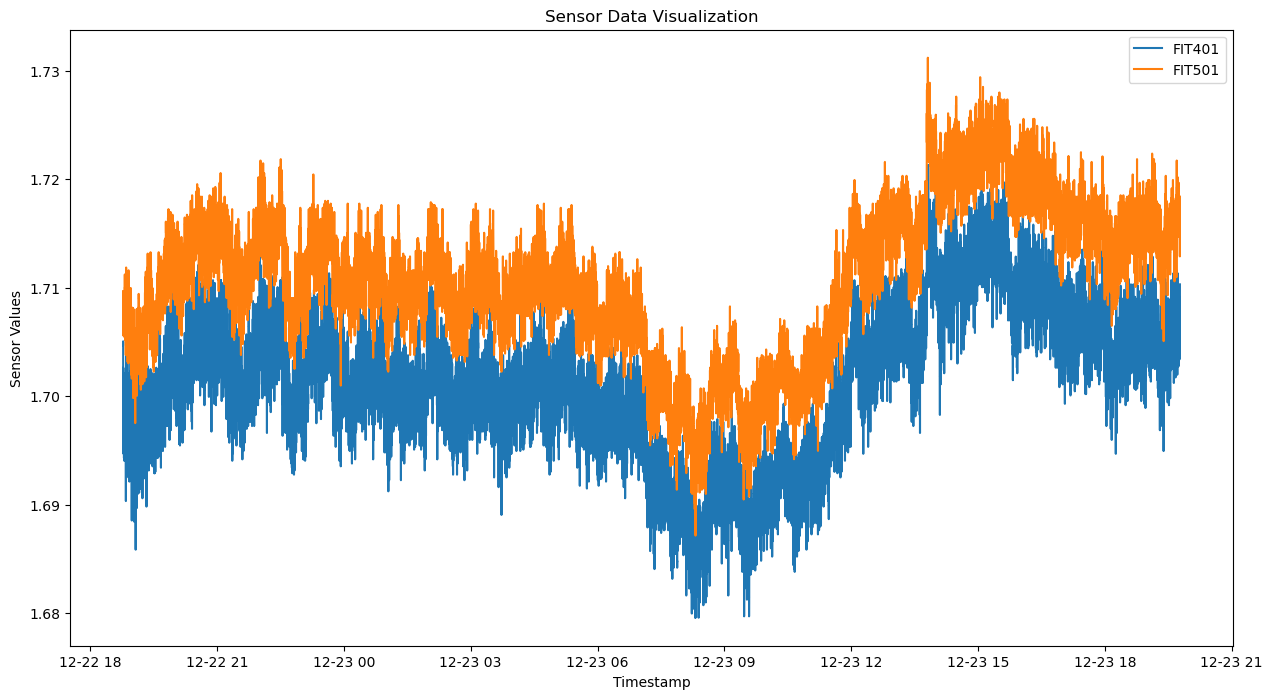

In [6]:
#same
visualize_sensor_data(train_data, window=(0, 100000), sensors=['FIT401', 'FIT501'])
visualize_sensor_data(train_data, window=(10000, 100000), sensors=['FIT401', 'FIT501'])


Looking at different signals, we can take two new separate examples where two different signals follow similar periodic oscillations but their amplitude is different.

The first graph compares sensors 'FIT101' and 'MV101'. The interesting part is that FIT101 has greater fluctuations, sharper edges and more spikes in sensor data, while MV101 has fewer fluctuations and is more stable over time (at their peaks). Their common trait is that their major fluctuations (shown by the long vertical lines) occur at the same time, this could mean they measure the same variable or alternatively two variables that are interdependent (one depends on the other, or they both depend on a 3rd variable in the same relation).

The second graph shows a similar relationship between two new sensors, but compared to the first graph these fluctuations seem more similar to each other and more stable.

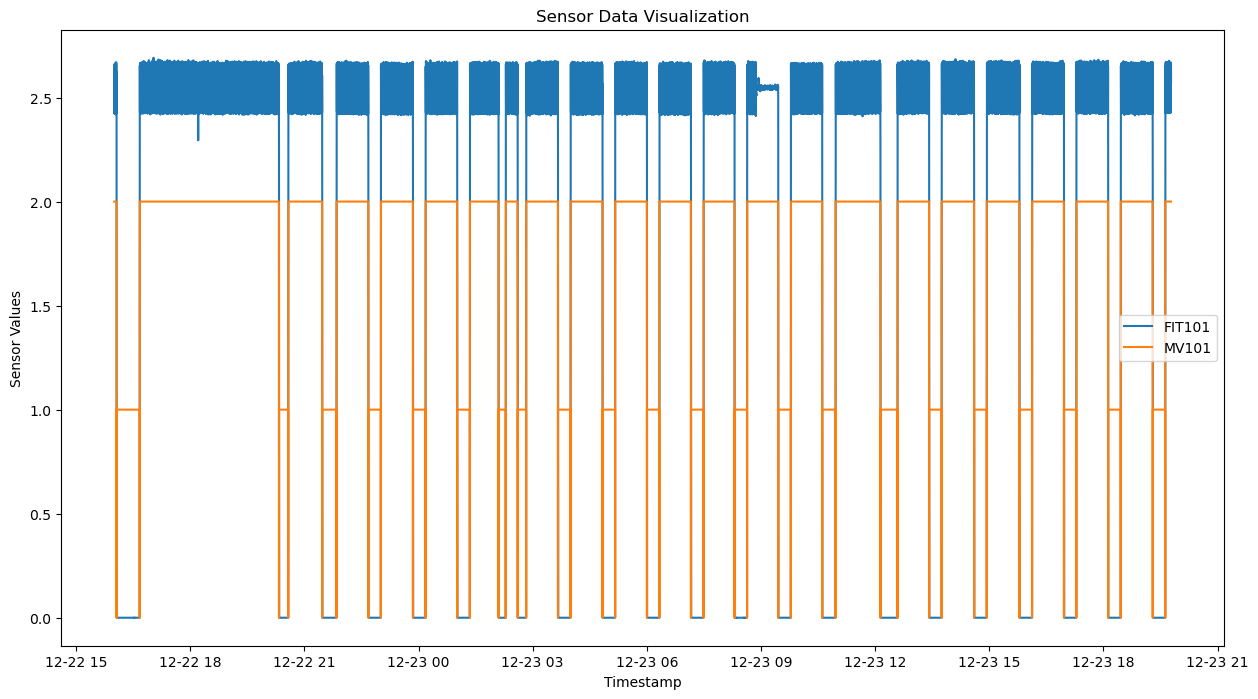

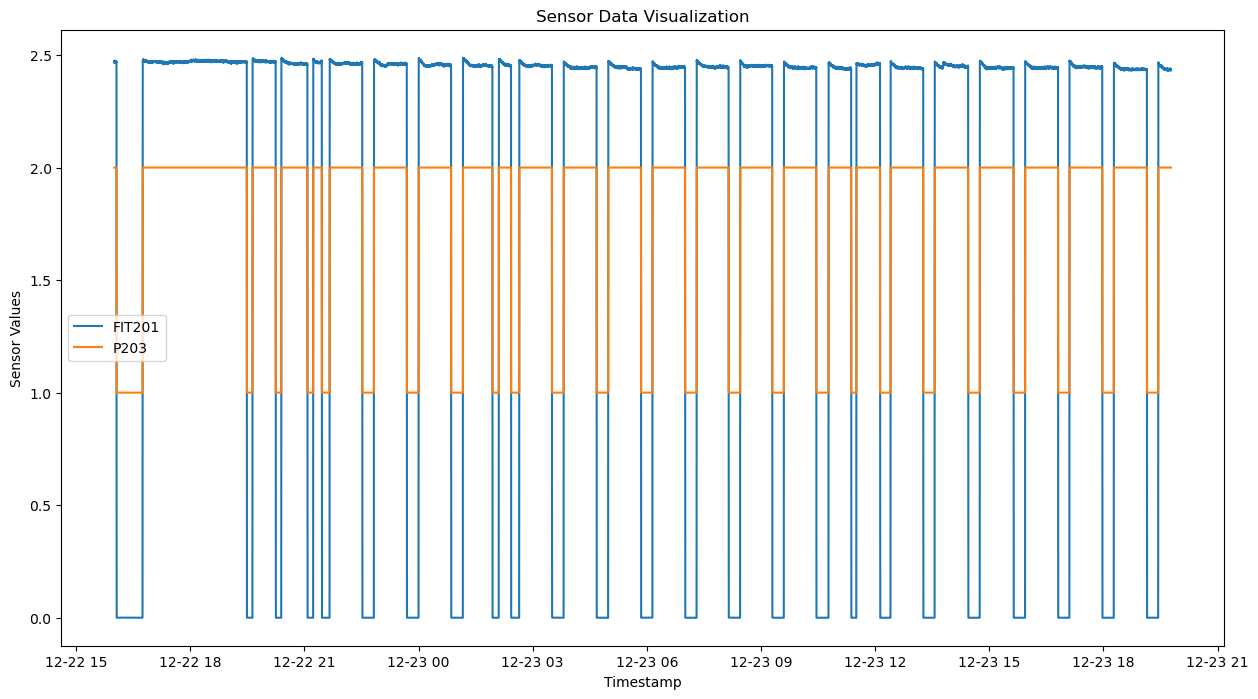

In [7]:
visualize_sensor_data(train_data, window=(0, 100000), sensors=['FIT101', 'MV101'])

#same
visualize_sensor_data(train_data, window=(0, 100000), sensors=['FIT201', 'P203'])


Here (below) we can observe three different sensors providing us with identical signals. From this we could conclude that the sensors are measuring the same variable.

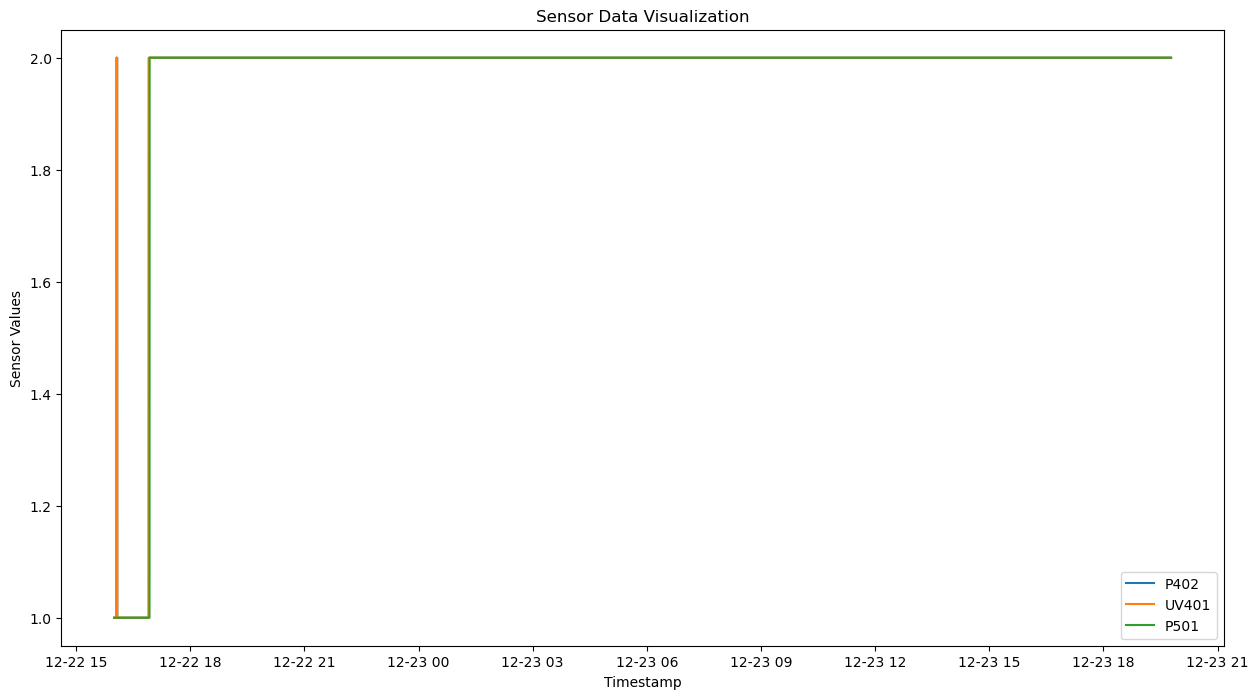

In [8]:
# same sensor data under different labels
visualize_sensor_data(train_data, window=(0, 100000), sensors=['P402', 'UV401', 'P501'])
#visualize_sensor_data(train_data, window=(10000, 100000), sensors=['P402', 'UV401', 'P501'])


We have seen many different behavioural patterns from the sensor data of different signals, some seem to be independent from each other, others heavily correlated, and some seem to be observing the exact same behaviour as other sensors. In these categories of signals some keep a constant value (probably as a result of a controlled variable), while in others we can observe cyclic behaviour (eg. 'LIT101').

----

## DTW implementation

In [9]:
def sliding_windows(data, window_size, stride):
    shape = (len(data) - window_size + 1, window_size)
    strides = (data.strides[0], data.strides[0])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)[::stride]

def approximate_dtw(seq1, seq2):
    n = len(seq1)
    cost = abs(seq1 - seq2[:n]).sum()
    return cost

def calculate_residuals_optimized(train_windows, test_windows, sample_size=100):
    sampled_train_windows = train_windows[np.random.choice(len(train_windows), sample_size, replace=False)]
    residuals = []
    for test_window in test_windows:
        distances = [approximate_dtw(test_window, train_window) for train_window in sampled_train_windows]
        residuals.append(min(distances))
    return np.array(residuals)


def detect_dtw_anomalies(train_data, test_data, sensor, window_size=50, stride=25, threshold_percentile=95, sample_size=100, plot=True):
    train_signal = train_data[sensor].values
    test_signal = test_data[sensor].values
    train_windows = sliding_windows(train_signal, window_size, stride)
    test_windows = sliding_windows(test_signal, window_size, stride)
    residuals = calculate_residuals_optimized(train_windows, test_windows, sample_size)
    
    threshold = np.percentile(residuals, threshold_percentile)
    anomalies = np.where(residuals > threshold)[0]
    
    if plot:
        plt.figure(figsize=(15, 6))
        plt.plot(residuals, label="DTW Distances (Residuals)", color="blue")
        plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold ({threshold_percentile}th percentile)")
        plt.scatter(anomalies, residuals[anomalies], color='orange', label="Anomalies", zorder=5)
        plt.title(f"DTW Anomaly Detection: {sensor}")
        plt.xlabel("Sliding Window Index")
        plt.ylabel("DTW Distance")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return anomalies, residuals, threshold

def compare_dtw_detection(train_data, test_data, sensors, window_sizes, strides, threshold_percentile=95, sample_size=100):
    for sensor in sensors:
        for window_size, stride in zip(window_sizes, strides):
            print(f"Analyzing {sensor} with window size {window_size} and stride {stride}")
            anomalies, residuals, threshold = detect_dtw_anomalies(
                train_data, test_data, sensor, window_size, stride, threshold_percentile, sample_size
            )
            print(f"  - Anomalies detected: {len(anomalies)}")
            print(f"  - Threshold used: {threshold:.2f}")

Testing various window sizes and strides.

Analyzing FIT101 with window size 50 and stride 10


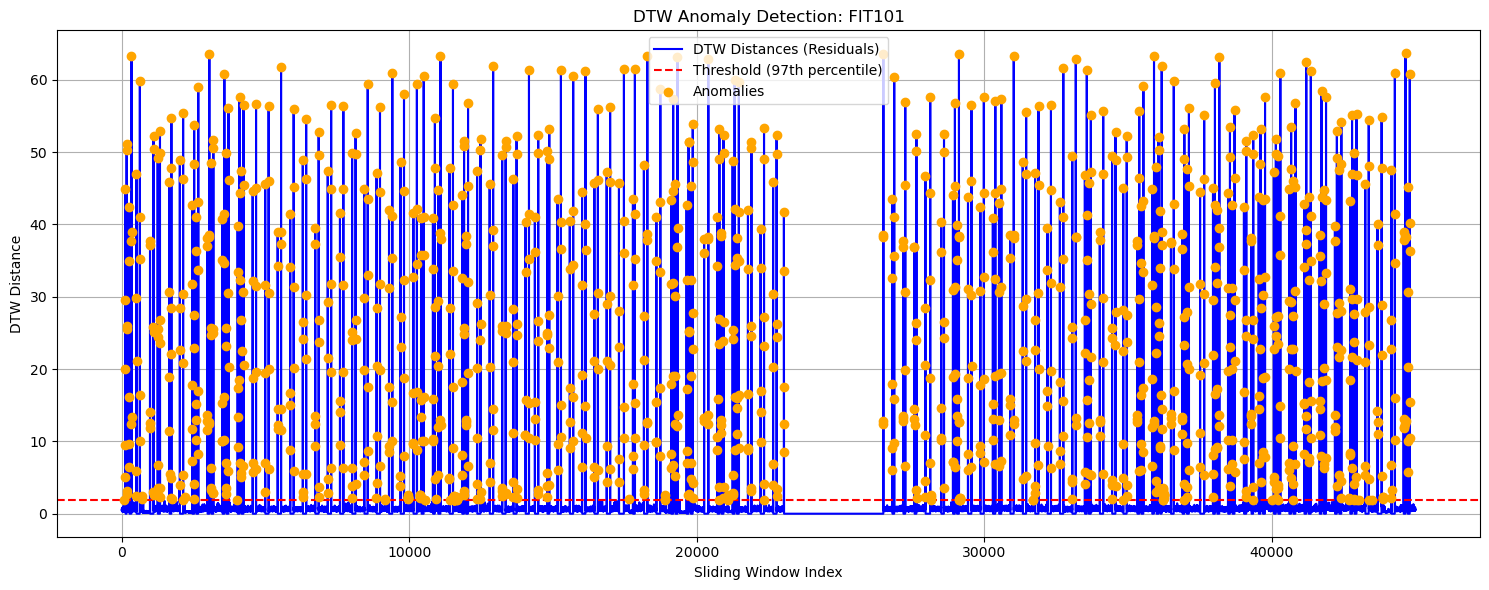

  - Anomalies detected: 1350
  - Threshold used: 1.84
Analyzing FIT101 with window size 100 and stride 25


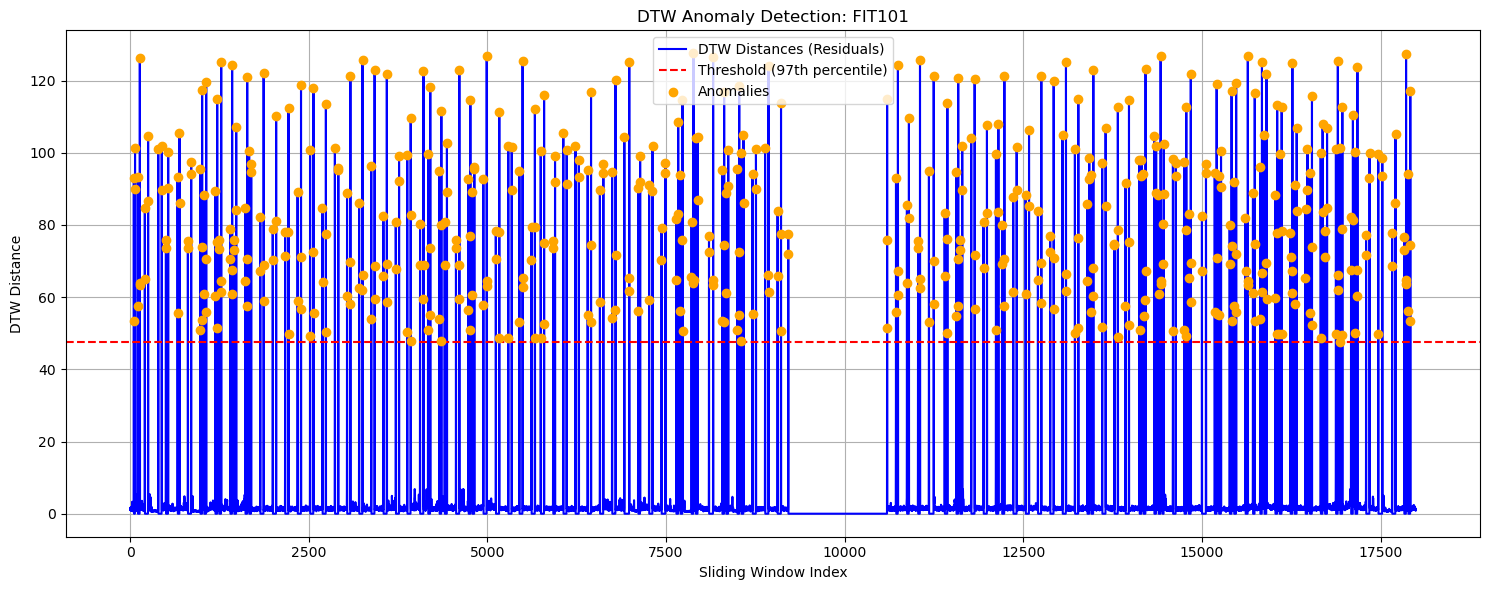

  - Anomalies detected: 540
  - Threshold used: 47.49
Analyzing FIT101 with window size 200 and stride 50


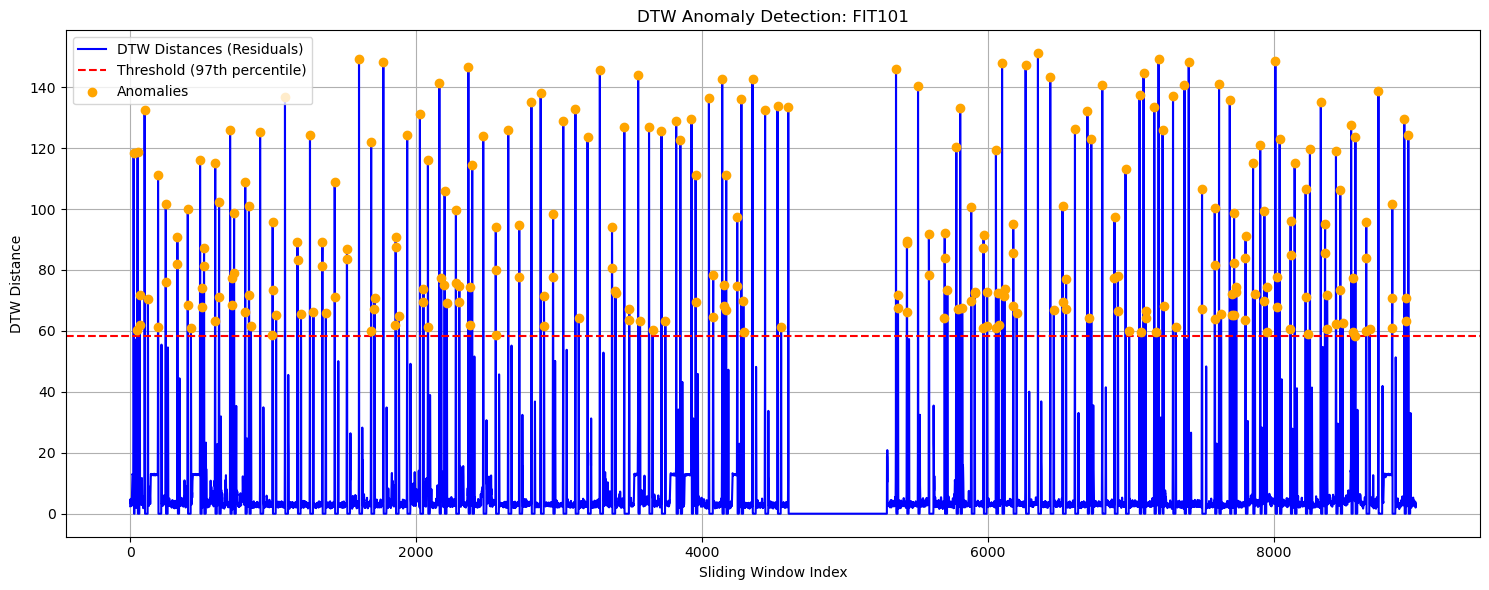

  - Anomalies detected: 270
  - Threshold used: 58.32
Analyzing LIT101 with window size 50 and stride 10


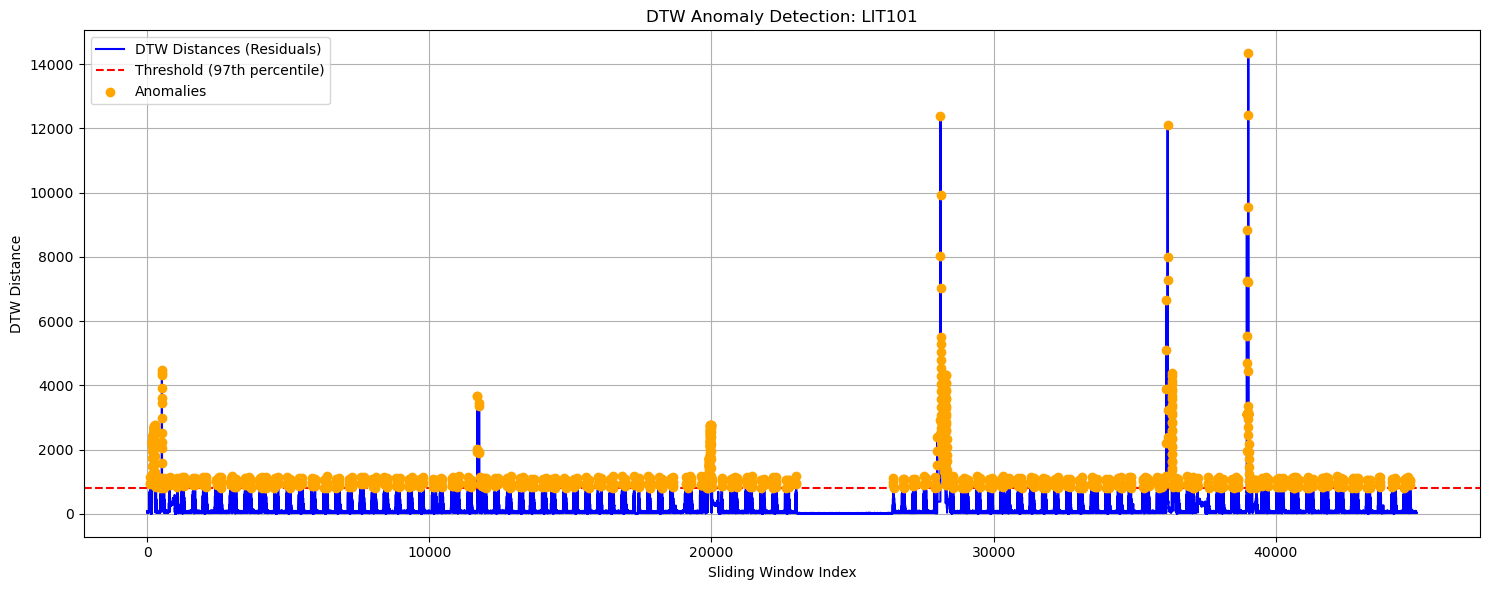

  - Anomalies detected: 1350
  - Threshold used: 802.58
Analyzing LIT101 with window size 100 and stride 25


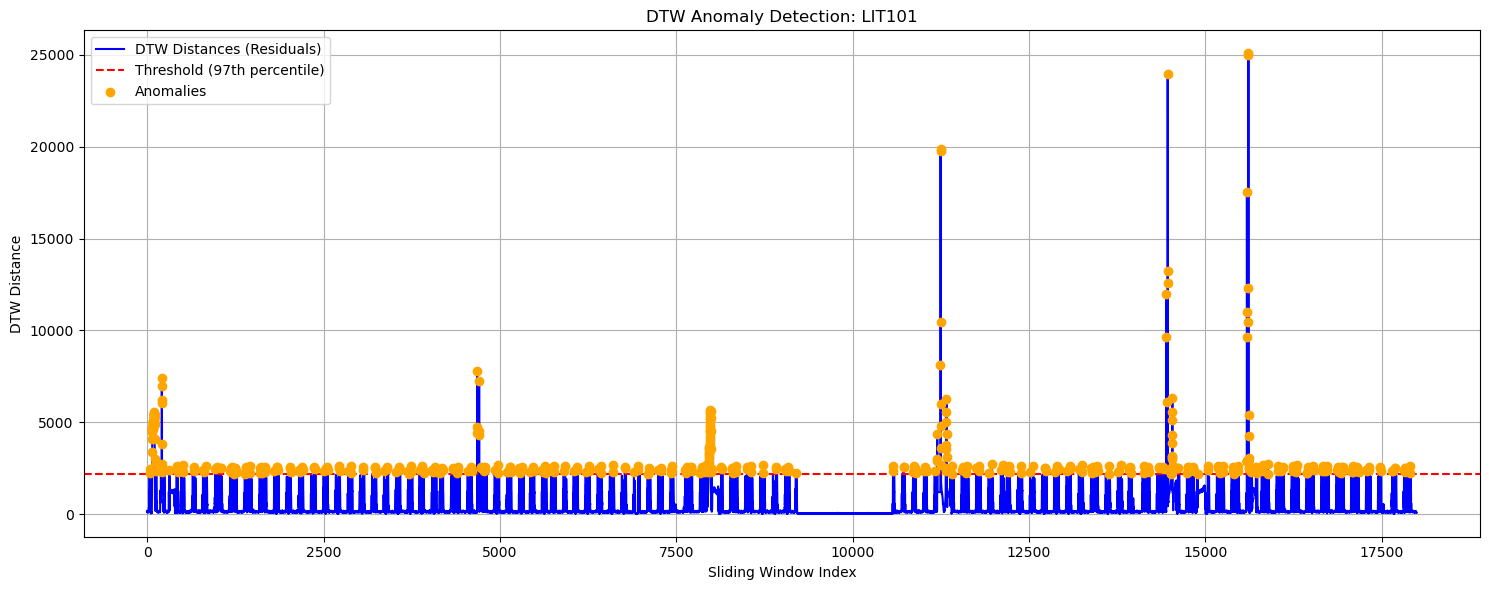

  - Anomalies detected: 540
  - Threshold used: 2204.95
Analyzing LIT101 with window size 200 and stride 50


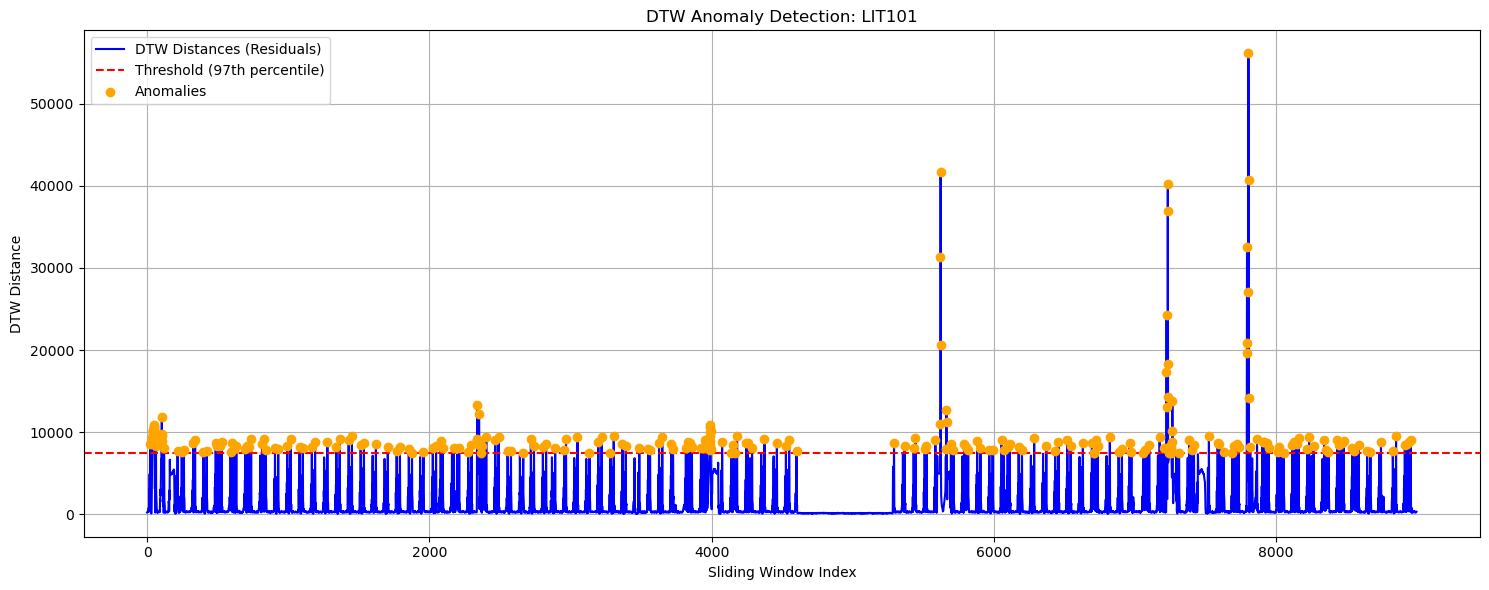

  - Anomalies detected: 270
  - Threshold used: 7407.23


In [10]:
sensors = ['FIT101', 'LIT101']
window_sizes = [50, 100, 200]
strides = [10, 25, 50]

compare_dtw_detection(
    train_data=train_data,
    test_data=test_data,
    sensors=sensors,
    window_sizes=window_sizes,
    strides=strides,
    threshold_percentile=97,
    sample_size=100
)

#### Best run

window_size = 100

stride = 25

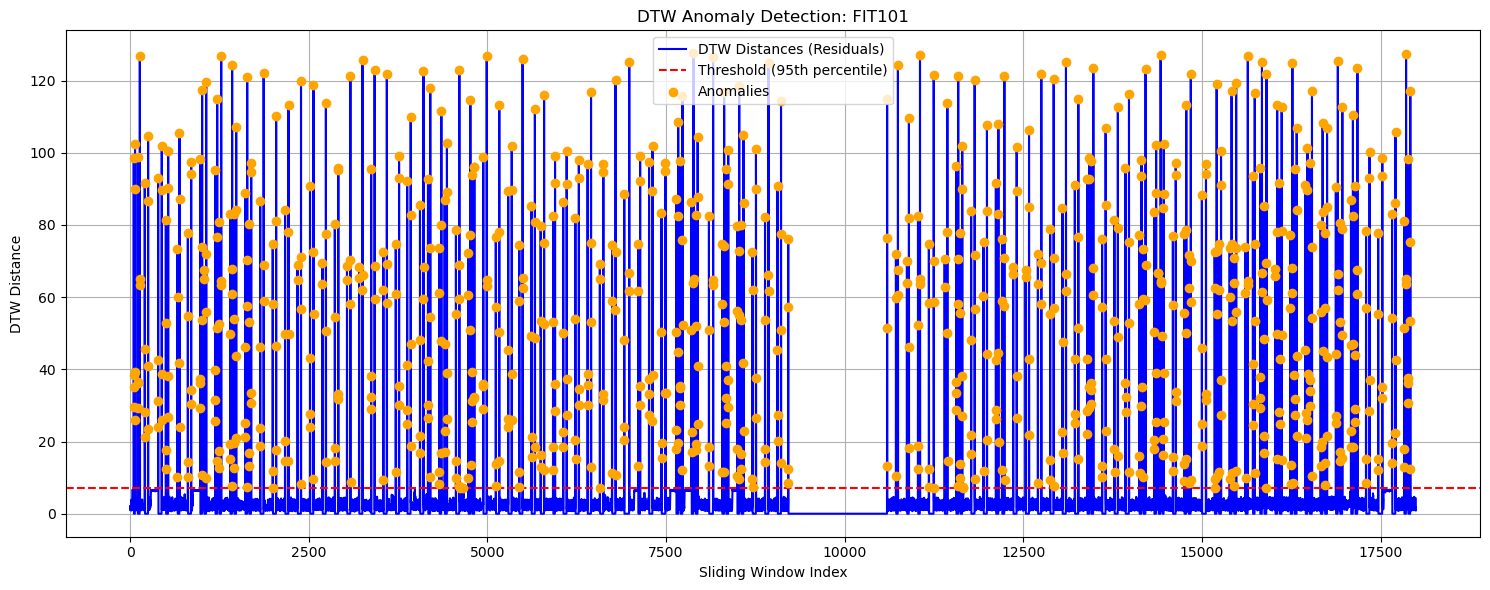

Number of anomalies: 900
Threshold used: 6.990229695999721


In [11]:
anomalies, residuals, threshold = detect_dtw_anomalies(
    train_data=train_data,
    test_data=test_data,
    sensor='FIT101',
    window_size=100,
    stride=25,
    threshold_percentile=95,
    sample_size=50
)

print(f"Number of anomalies: {len(anomalies)}")
print(f"Threshold used: {threshold}")

Stride - 25, window size - 100 achieves a solution of 900 anomalies and threshold at 6.95, which from the plot seems like a decent threshold for the anomalies.

I would prefer a stride to always be 50% of window size and reduce window size to 50, because having higher window size increases threshold significantly.
However, using strie - 25 and window size - 100 does not yield too large threshold which satisfies me.

----------

## PCA implementation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

def remove_constant_columns(data):
    data = np.asarray(data)
    variances = np.var(data, axis=0)
    non_constant_columns = variances > 0
    return data[:, non_constant_columns], non_constant_columns

def pca_decomposition(data, n_components):
    data = np.asarray(data)
    data_filtered, non_constant_columns = remove_constant_columns(data)
    data_mean = np.mean(data_filtered, axis=0)
    data_std = np.std(data_filtered, axis=0)
    data_standardized = (data_filtered - data_mean) / data_std
    U, S, Vt = svd(data_standardized, full_matrices=False)
    components = Vt[:n_components]
    projection = np.dot(data_standardized, components.T)
    reconstruction_filtered = np.dot(projection, components) * data_std + data_mean
    reconstruction = np.zeros_like(data)
    reconstruction[:, non_constant_columns] = reconstruction_filtered
    return reconstruction, components, projection

def pca_residuals(original, reconstructed):
    return np.mean((original - reconstructed) ** 2, axis=1)

In [13]:

def plot_residuals(residuals, threshold, title="Residuals with Threshold"):
    plt.figure(figsize=(15, 6))
    plt.plot(residuals, label="Residuals", color="blue")
    plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold ({threshold:.2f})")
    plt.scatter(np.where(residuals > threshold)[0], residuals[residuals > threshold], color='orange', label="Anomalies")
    plt.title(title)
    plt.xlabel("Data Index")
    plt.ylabel("Residual")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pca_projection(projected_data, anomalies, title="PCA Projection"):
    plt.figure(figsize=(15, 8))
    plt.scatter(projected_data.iloc[:, 0], projected_data.iloc[:, 1], alpha=0.5, label='Normal Data', color='blue')
    plt.scatter(projected_data.iloc[anomalies, 0], projected_data.iloc[anomalies, 1], alpha=0.8, label='Anomalies', color='orange')
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
def prepare_numeric_data(data):
    data = data.drop(columns=['Normal/Attack', 'Timestamp'])
    return data.select_dtypes(include=[np.number])

train_numeric = prepare_numeric_data(train_data)
test_numeric = prepare_numeric_data(test_data)

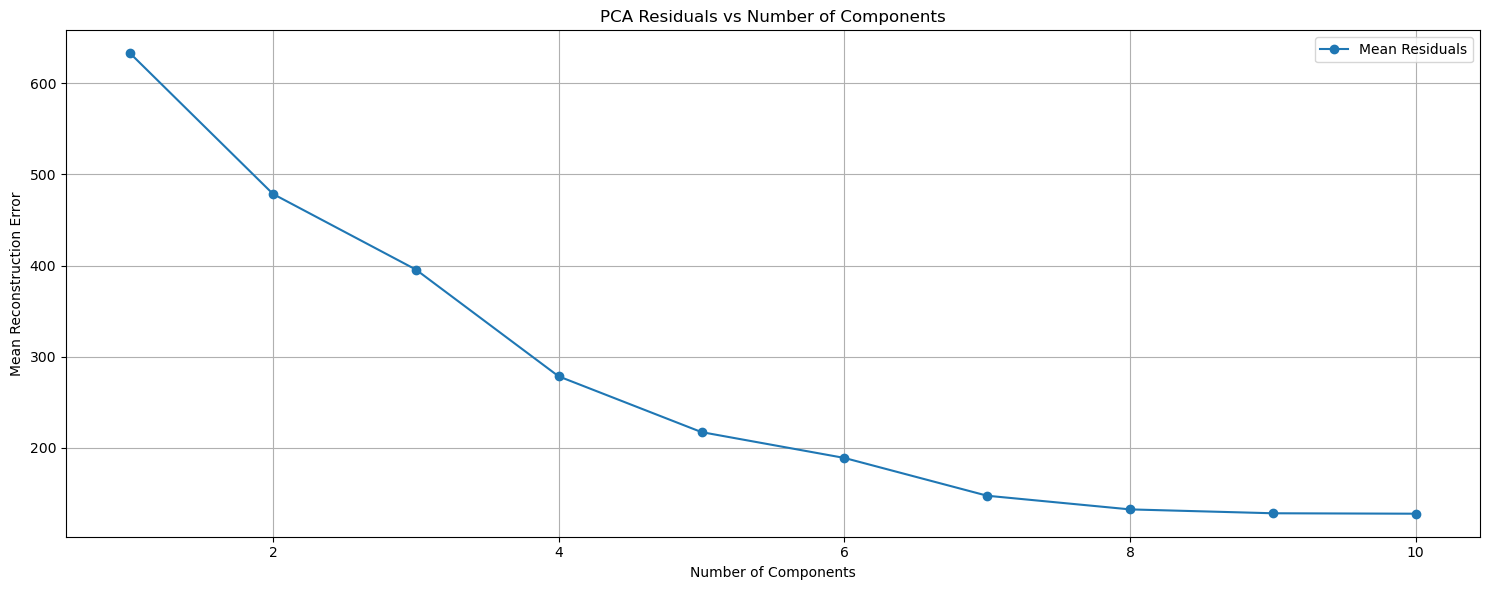

In [15]:
def analyze_pca_components(train_data, max_components=10):
    train_data = np.asarray(train_data)
    residuals = []
    for n in range(1, max_components + 1):
        reconstruction_train, _, _ = pca_decomposition(train_data, n)
        residuals.append(np.mean(pca_residuals(train_data, reconstruction_train)))
    plt.figure(figsize=(15, 6))
    plt.plot(range(1, max_components + 1), residuals, marker='o', label="Mean Residuals")
    plt.title("PCA Residuals vs Number of Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Mean Reconstruction Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

analyze_pca_components(train_numeric, max_components=10)

8 components seems like a sufficient amount given the graph above of error and component count as each additional components yields diminishing returns.

obviously, the more the better, but we are also saving resources here by choosing a lower amount of components!

### lets begin with PCA

In [16]:
def plot_residuals(residuals, threshold=None):
    plt.figure(figsize=(15, 6))
    plt.plot(residuals, label="Residuals", color="blue")
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold ({threshold} value)")
    plt.title("Residuals")
    plt.xlabel("Data Point Index")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_anomalies(data, residuals, threshold, anomalies):
    plt.figure(figsize=(15, 6))
    plt.plot(residuals, label="Residuals", color="blue")
    plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold ({threshold} value)")
    plt.scatter(anomalies, residuals[anomalies], color='orange', label="Anomalies", zorder=5)
    plt.title("Anomaly Detection")
    plt.xlabel("Data Point Index")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def perform_anomaly_detection(train_data, test_data, n_components, threshold_percentile=97, threshold=None):
    reconstruction_train, _, _ = pca_decomposition(train_data, n_components)
    residuals_train = pca_residuals(train_data, reconstruction_train)
    if threshold is None:
        threshold = np.percentile(residuals_train, threshold_percentile)
    anomalies_train = np.where(residuals_train > threshold)[0]
    reconstruction_test, _, _ = pca_decomposition(test_data, n_components)
    residuals_test = pca_residuals(test_data, reconstruction_test)
    anomalies_test = np.where(residuals_test > threshold)[0]
    return residuals_train, residuals_test, threshold, anomalies_train, anomalies_test

def remove_anomalies(data, anomalies):
    return np.delete(data, anomalies, axis=0)

def plot_pca_components(data, components, projection, anomalies=None):
    plt.figure(figsize=(15, 6))
    plt.scatter(projection[:, 0], projection[:, 1], alpha=0.7, label="Data Points")
    if anomalies is not None:
        plt.scatter(projection[anomalies, 0], projection[anomalies, 1], color='orange', label="Anomalies", zorder=5)
    plt.quiver(
        0, 0, components[0, 0], components[0, 1],
        angles="xy", scale_units="xy", scale=1, color="red", label="Component 1"
    )
    plt.quiver(
        0, 0, components[1, 0], components[1, 1],
        angles="xy", scale_units="xy", scale=1, color="green", label="Component 2"
    )
    plt.title("PCA Components (First Two)")
    plt.xlabel("Projection on Component 1")
    plt.ylabel("Projection on Component 2")
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
n_components = 8train_numeric

SyntaxError: invalid decimal literal (2128294485.py, line 1)

Threshold for anomaly detection: 537.8090637062559
Number of anomalies in training data: 14904
Number of anomalies in test data: 44121


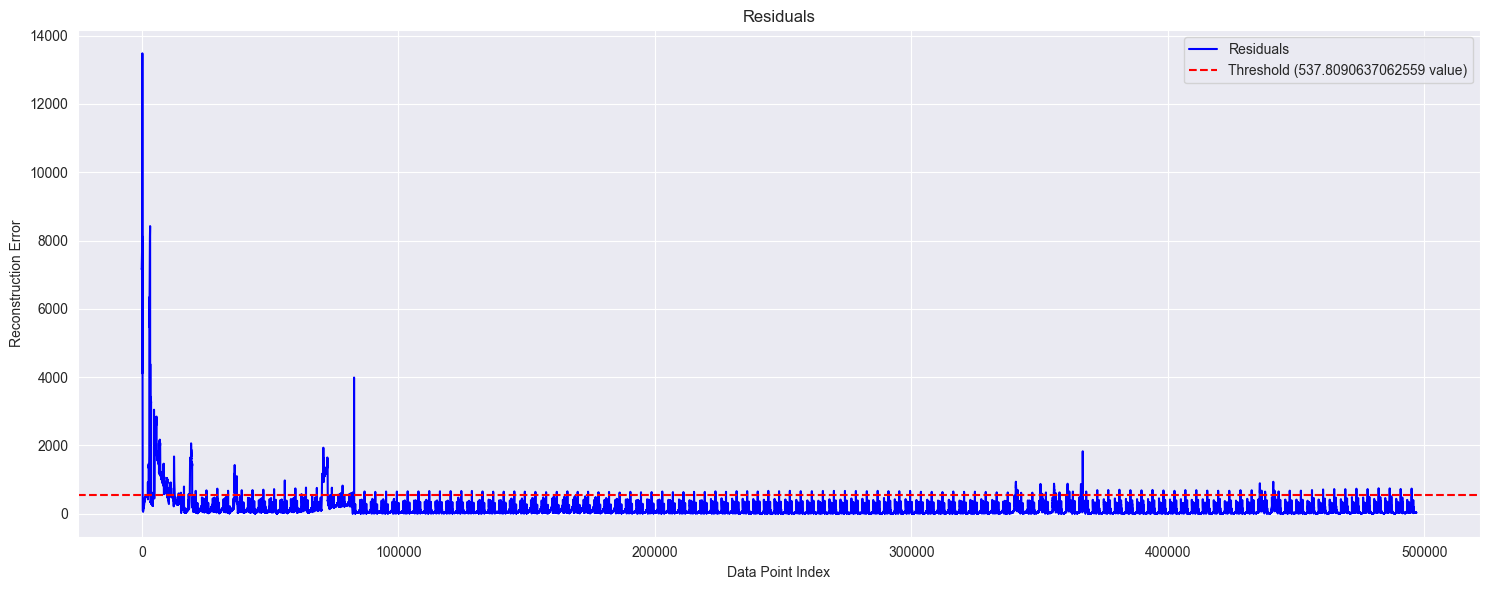

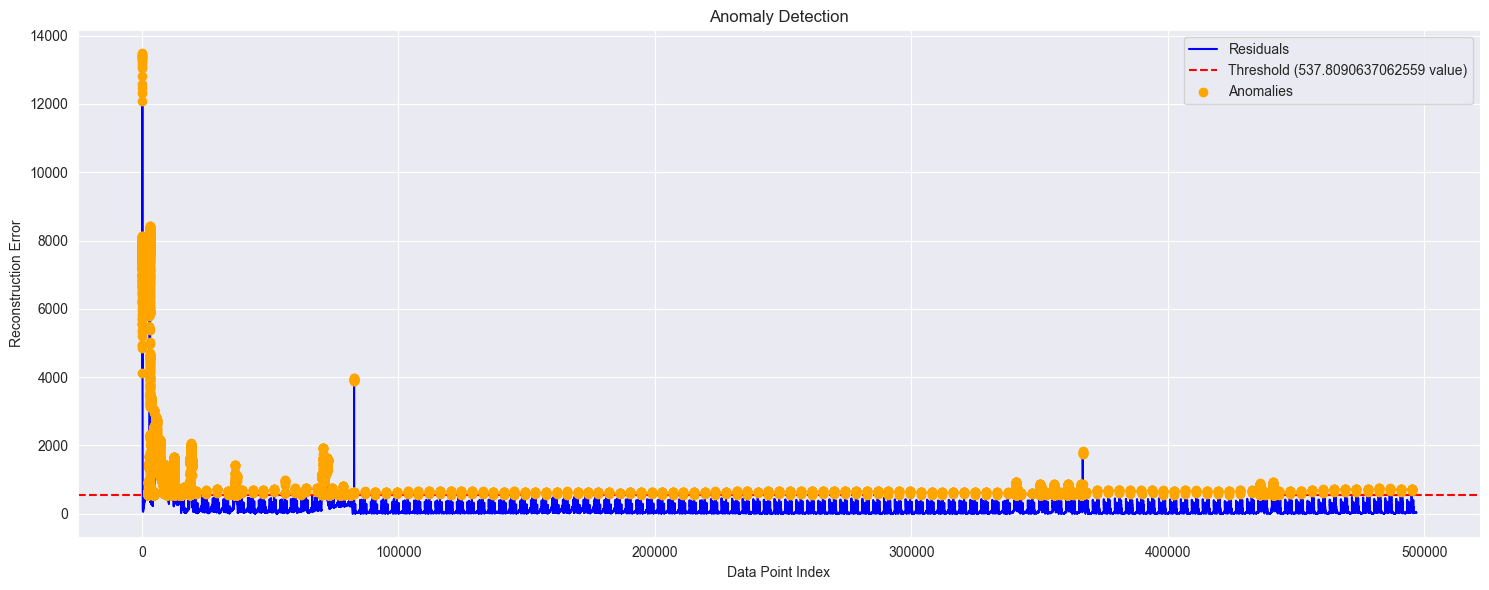

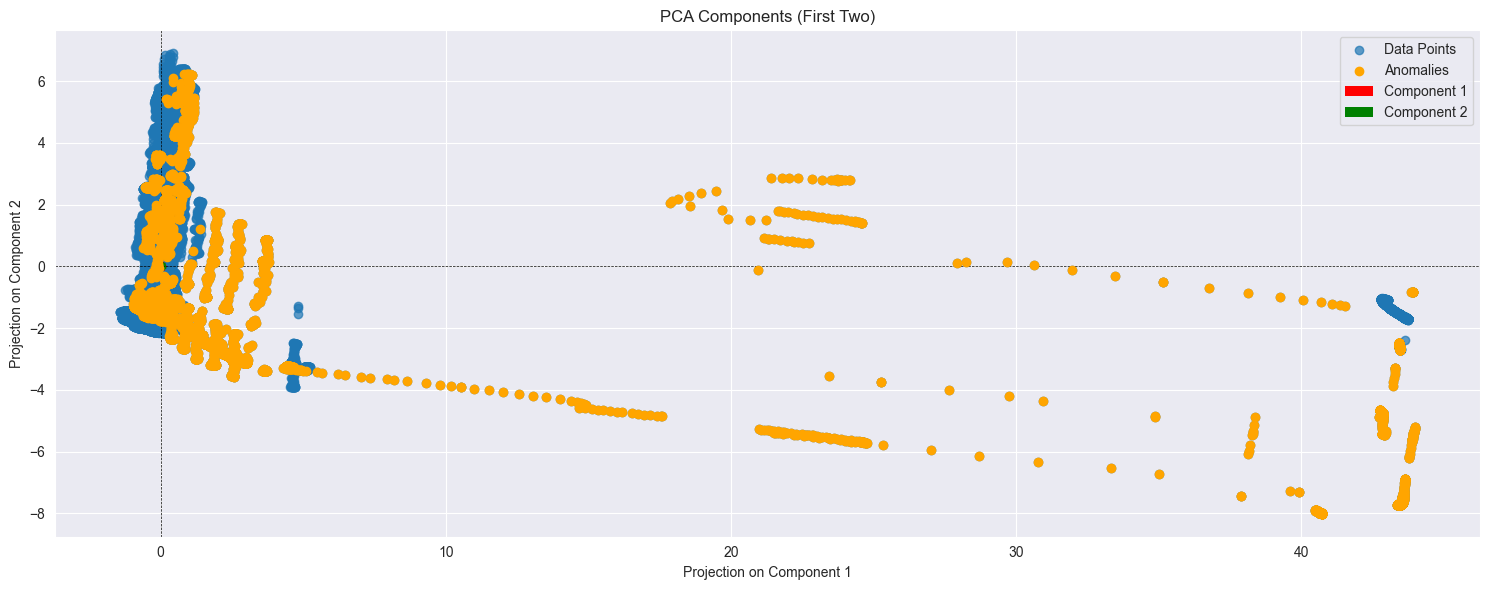

Number of anomalies in cleaned training data: 2351
Number of anomalies in test data after cleaning: 44121


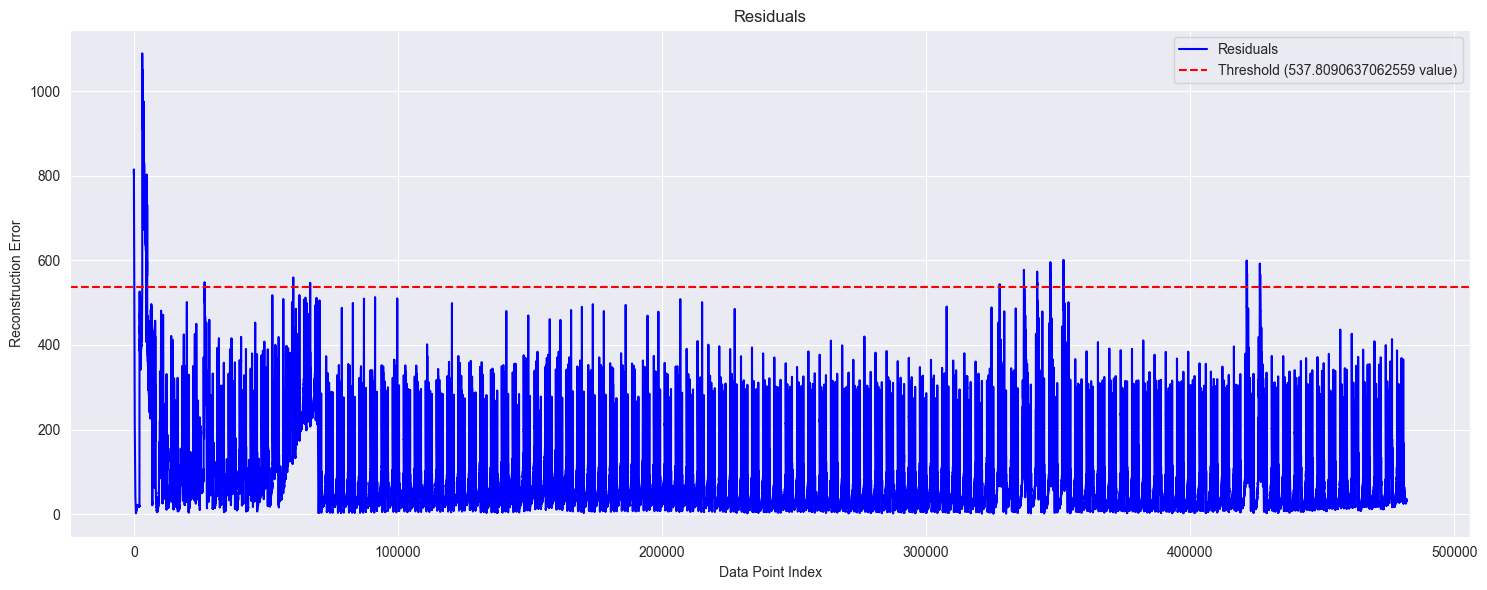

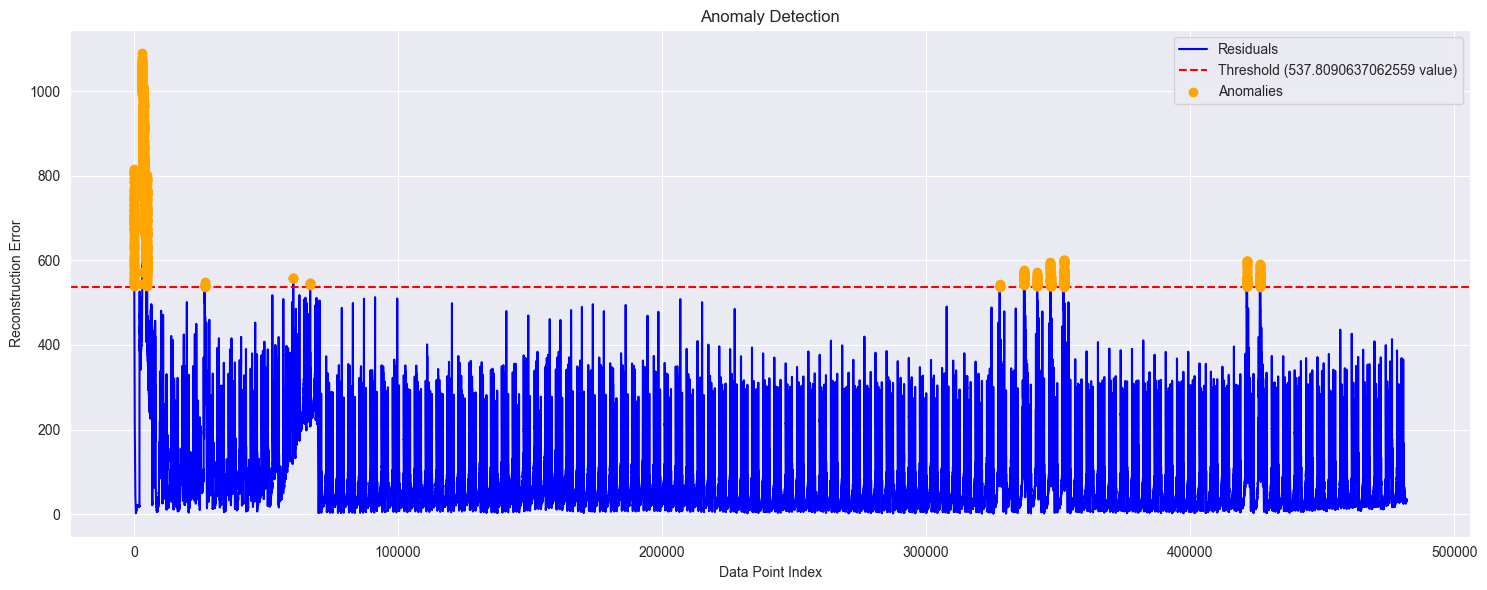

In [ ]:
residuals_train, residuals_test, threshold, anomalies_train, anomalies_test = perform_anomaly_detection(train_numeric, test_numeric, n_components)

print(f"Threshold for anomaly detection: {threshold}")
print(f"Number of anomalies in training data: {len(anomalies_train)}")
print(f"Number of anomalies in test data: {len(anomalies_test)}")


plot_residuals(residuals_train, threshold)
plot_anomalies(train_numeric, residuals_train, threshold, anomalies_train)

reconstruction_train, components_train, projection_train = pca_decomposition(train_numeric, n_components)
plot_pca_components(train_numeric, components_train, projection_train, anomalies_train)

train_cleaned = remove_anomalies(train_numeric, anomalies_train)

residuals_train_cleaned, residuals_test_cleaned, threshold_cleaned, anomalies_train_cleaned, anomalies_test_cleaned = perform_anomaly_detection(train_cleaned, test_numeric, n_components, threshold=threshold)

print(f"Number of anomalies in cleaned training data: {len(anomalies_train_cleaned)}")
print(f"Number of anomalies in test data after cleaning: {len(anomalies_test_cleaned)}")

plot_residuals(residuals_train_cleaned, threshold_cleaned)
plot_anomalies(train_cleaned, residuals_train_cleaned, threshold_cleaned, anomalies_train_cleaned)

surprisingly, i am pretty happy with this result! i am exceptionally happy the anomalies i see on the test set!

this is quite passive threshold of 537, which could certainly be lower depending on the case, but if this is sensor data and we have anomalies every day, i would like to have anomalies that actually matter, rather than notifications every hour!

#### lets test using 95'th percentile

Threshold for anomaly detection: 379.07850972605775
Number of anomalies in training data: 24840
Number of anomalies in test data: 61243


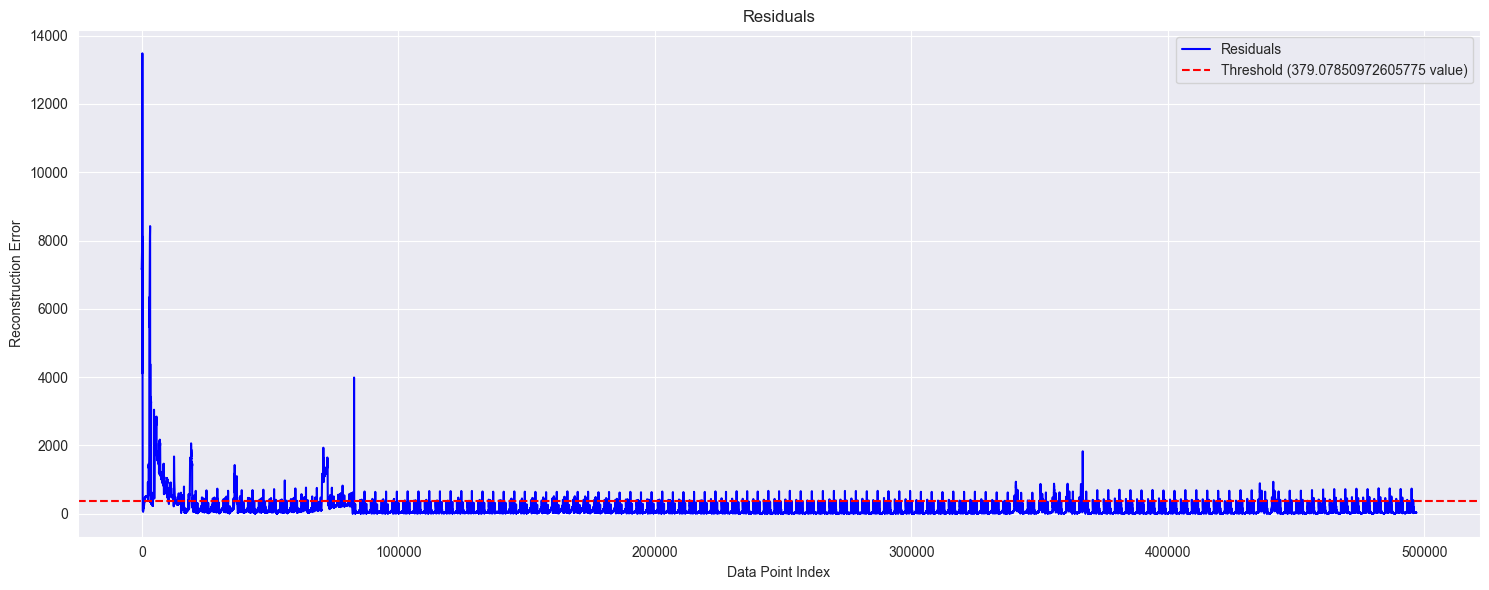

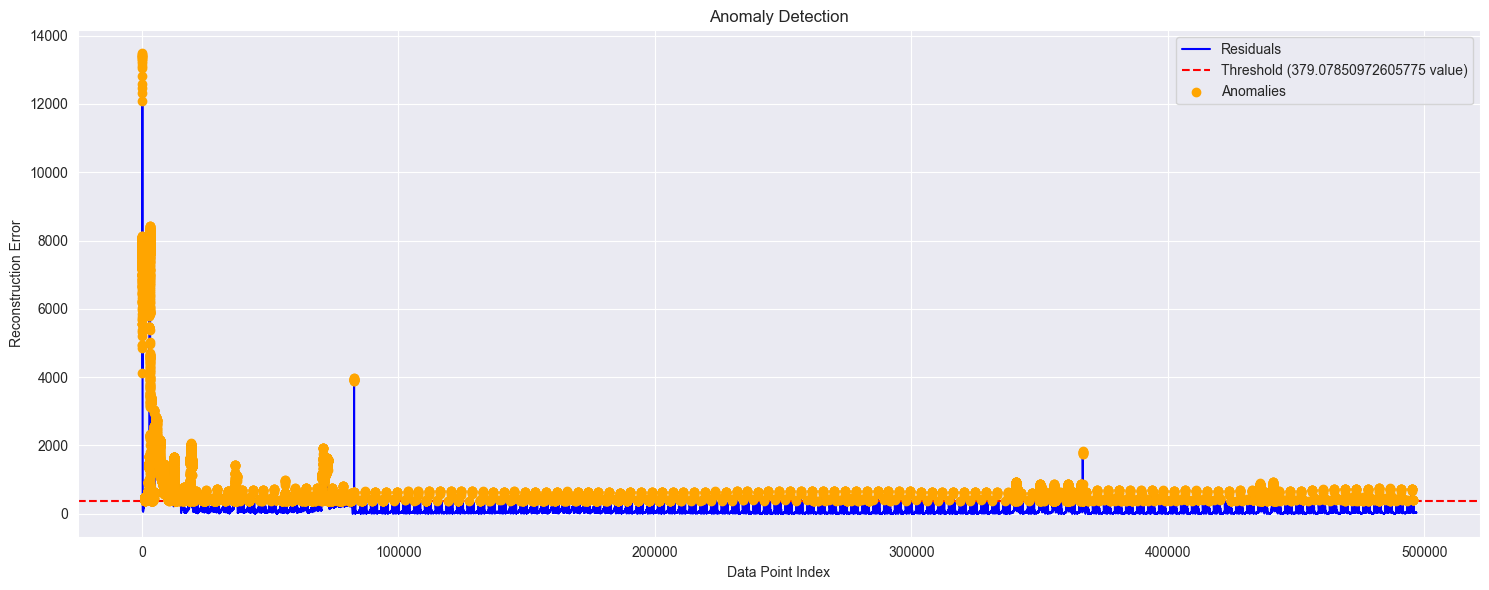

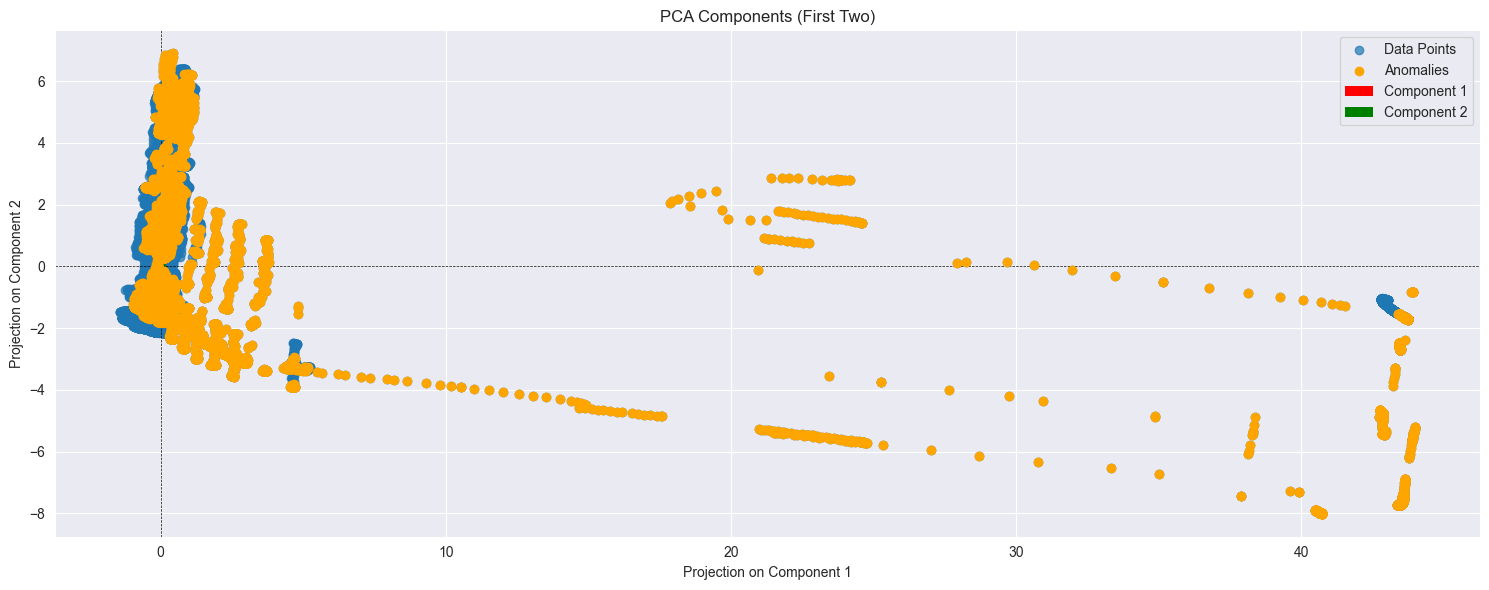

Number of anomalies in cleaned training data: 1168
Number of anomalies in test data after cleaning: 61243


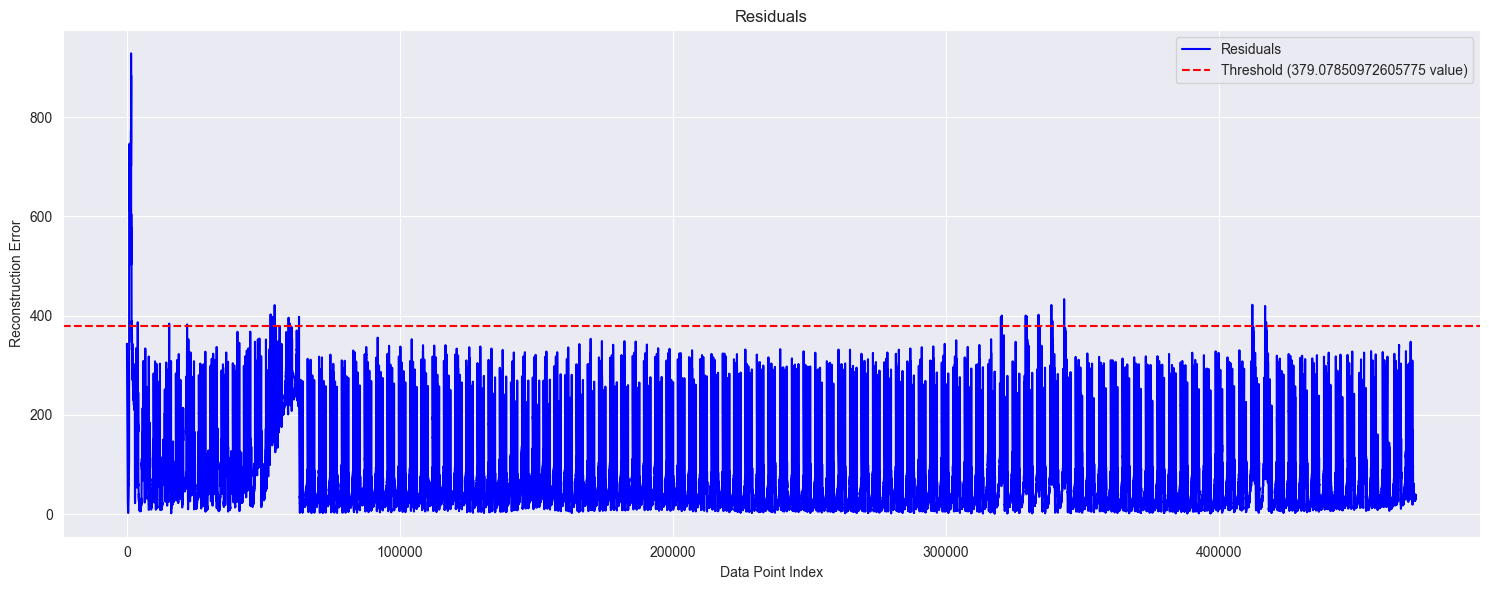

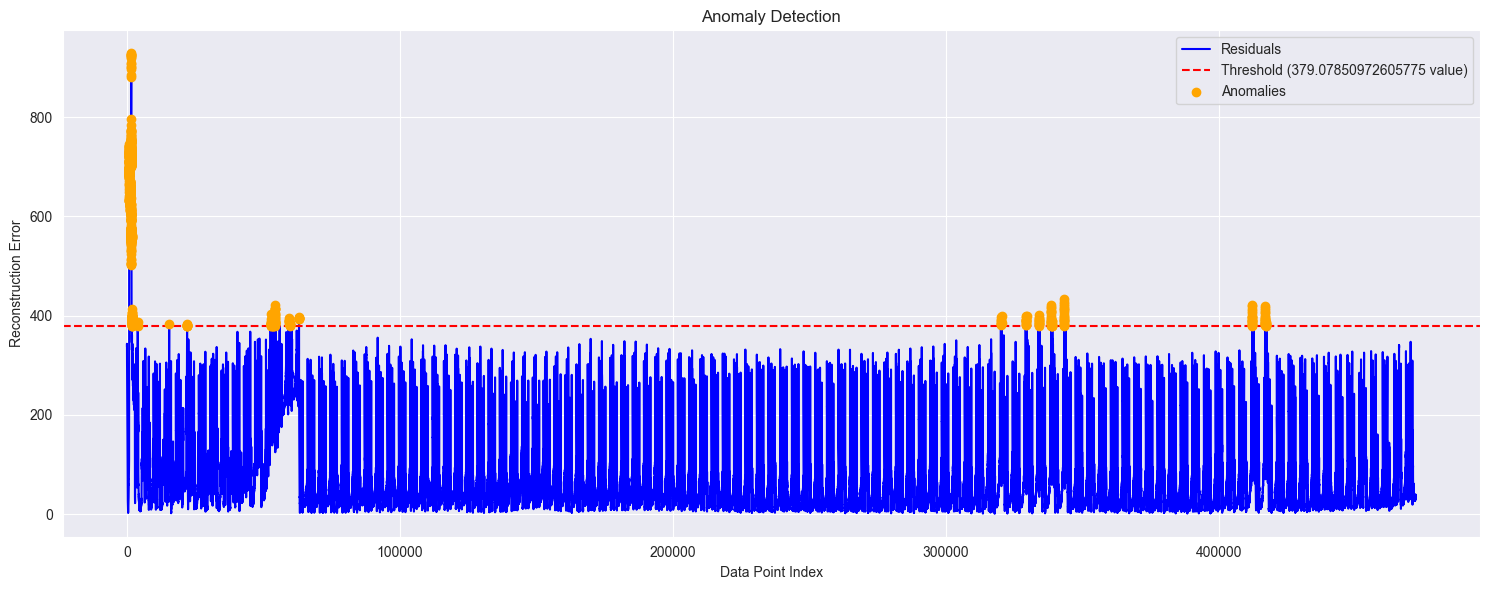

In [ ]:
residuals_train, residuals_test, threshold, anomalies_train, anomalies_test = perform_anomaly_detection(train_numeric, test_numeric, n_components, threshold_percentile=95)

print(f"Threshold for anomaly detection: {threshold}")
print(f"Number of anomalies in training data: {len(anomalies_train)}")
print(f"Number of anomalies in test data: {len(anomalies_test)}")


plot_residuals(residuals_train, threshold)
plot_anomalies(train_numeric, residuals_train, threshold, anomalies_train)

reconstruction_train, components_train, projection_train = pca_decomposition(train_numeric, n_components)
plot_pca_components(train_numeric, components_train, projection_train, anomalies_train)

train_cleaned = remove_anomalies(train_numeric, anomalies_train)

residuals_train_cleaned, residuals_test_cleaned, threshold_cleaned, anomalies_train_cleaned, anomalies_test_cleaned = perform_anomaly_detection(train_cleaned, test_numeric, n_components, threshold=threshold)

print(f"Number of anomalies in cleaned training data: {len(anomalies_train_cleaned)}")
print(f"Number of anomalies in test data after cleaning: {len(anomalies_test_cleaned)}")

plot_residuals(residuals_train_cleaned, threshold_cleaned)
plot_anomalies(train_cleaned, residuals_train_cleaned, threshold_cleaned, anomalies_train_cleaned)

this is also seems like a great result with threshold of 379.

lets test using less components

In [ ]:
n_components = 5

Threshold for anomaly detection: 532.9844689132691
Number of anomalies in training data: 24840
Number of anomalies in test data: 45593


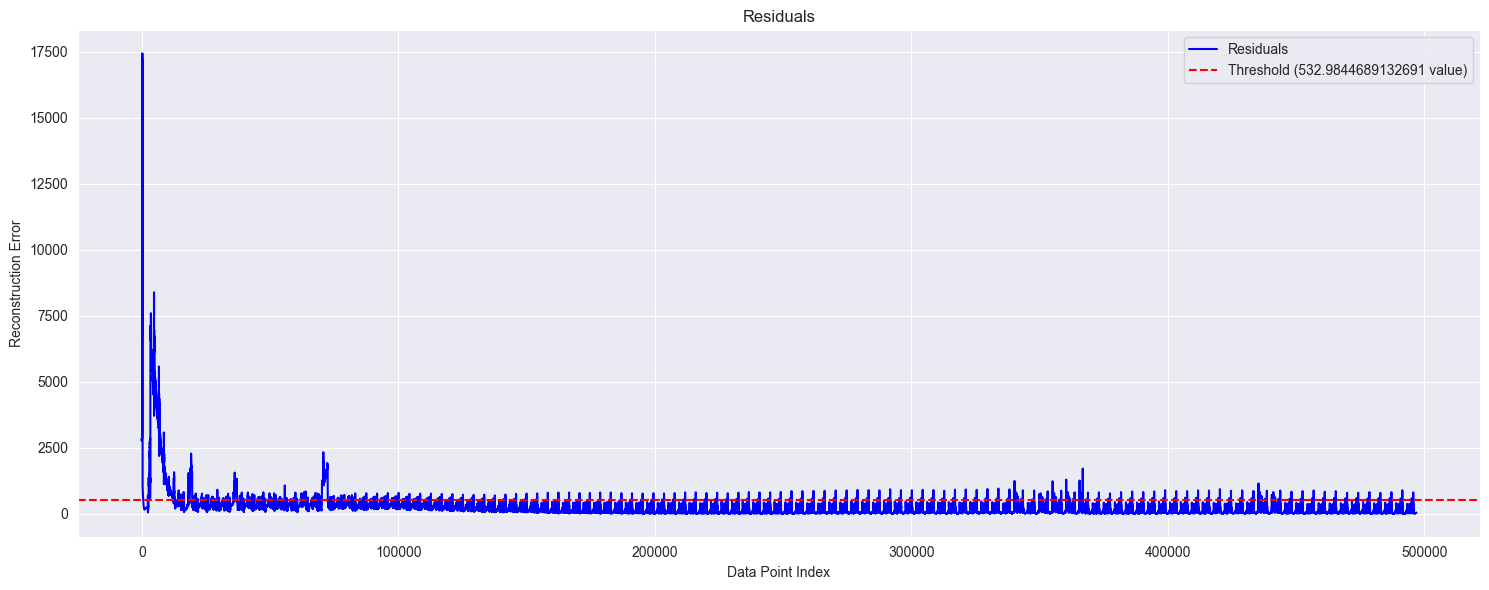

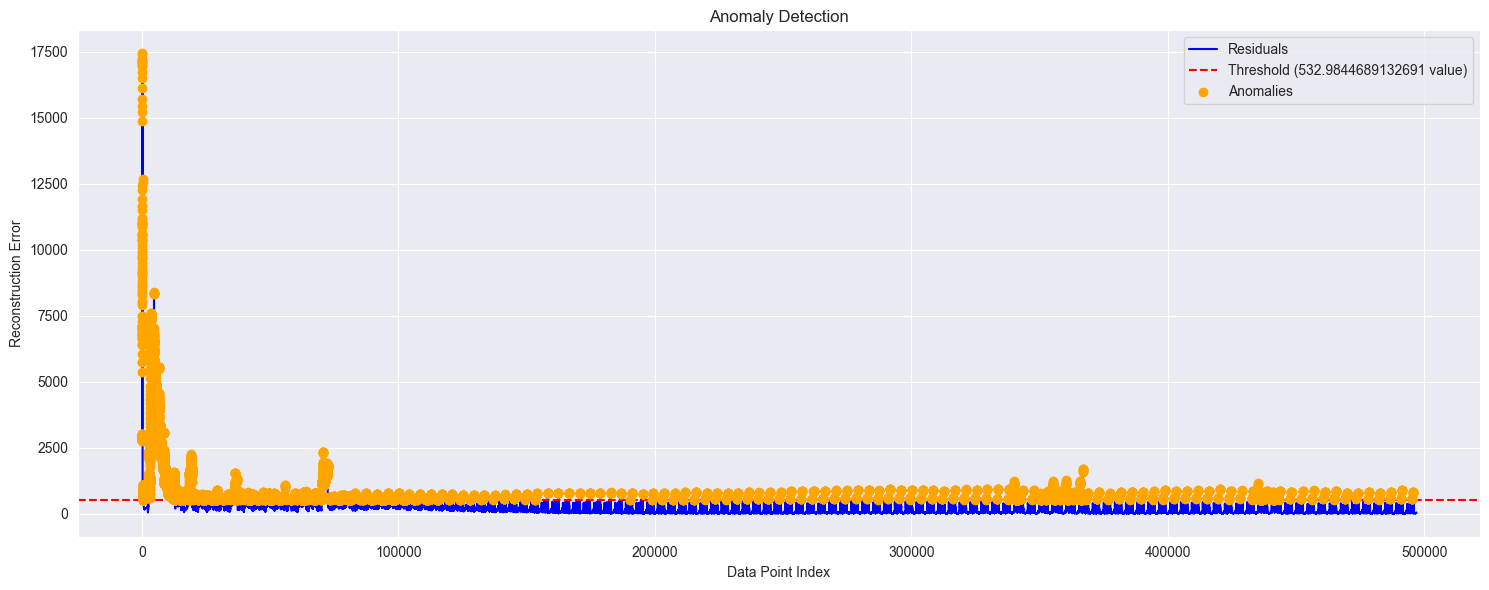

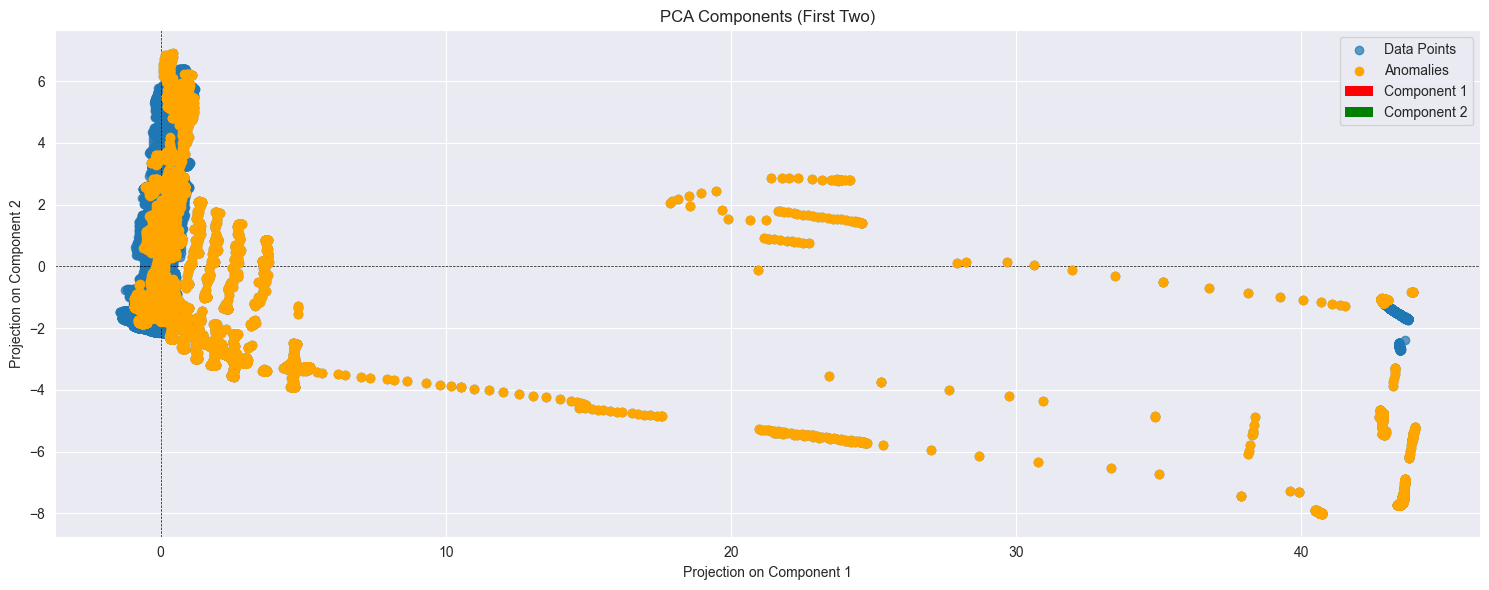

Number of anomalies in cleaned training data: 1878
Number of anomalies in test data after cleaning: 45593


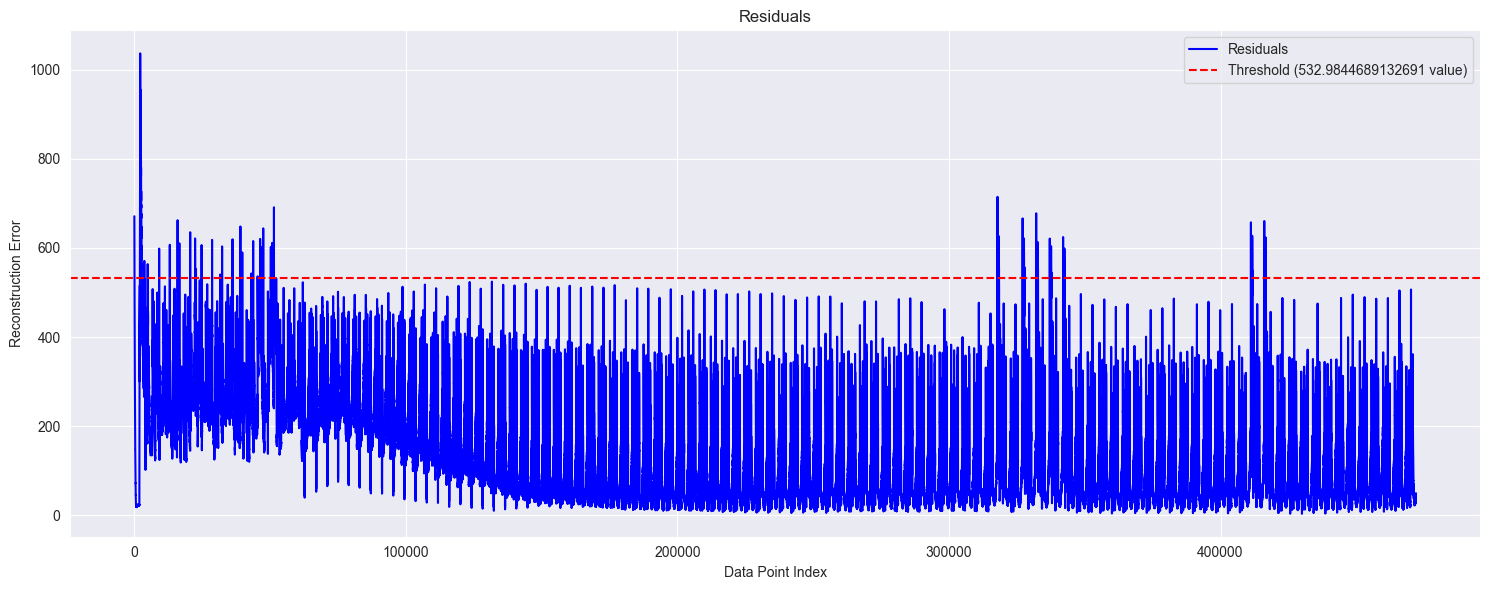

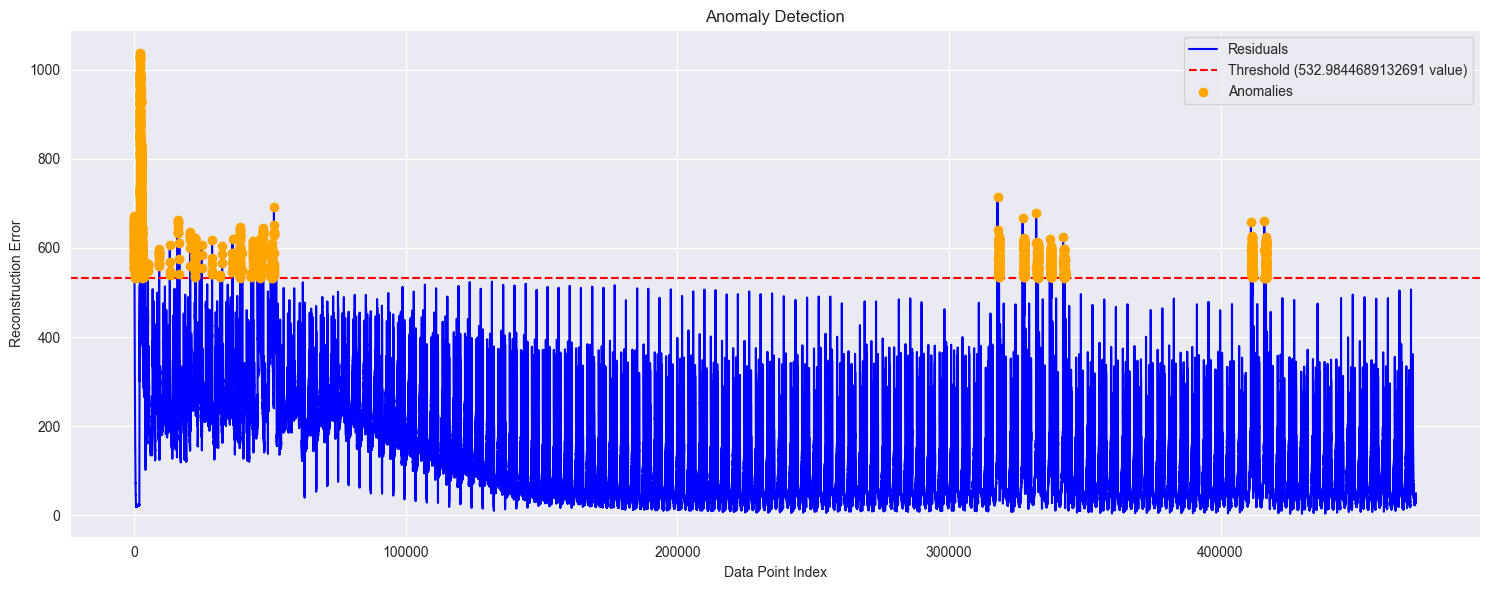

In [ ]:
residuals_train, residuals_test, threshold, anomalies_train, anomalies_test = perform_anomaly_detection(train_numeric, test_numeric, n_components, threshold_percentile=95)

print(f"Threshold for anomaly detection: {threshold}")
print(f"Number of anomalies in training data: {len(anomalies_train)}")
print(f"Number of anomalies in test data: {len(anomalies_test)}")


plot_residuals(residuals_train, threshold)
plot_anomalies(train_numeric, residuals_train, threshold, anomalies_train)

reconstruction_train, components_train, projection_train = pca_decomposition(train_numeric, n_components)
plot_pca_components(train_numeric, components_train, projection_train, anomalies_train)

train_cleaned = remove_anomalies(train_numeric, anomalies_train)

residuals_train_cleaned, residuals_test_cleaned, threshold_cleaned, anomalies_train_cleaned, anomalies_test_cleaned = perform_anomaly_detection(train_cleaned, test_numeric, n_components, threshold=threshold)

print(f"Number of anomalies in cleaned training data: {len(anomalies_train_cleaned)}")
print(f"Number of anomalies in test data after cleaning: {len(anomalies_test_cleaned)}")

plot_residuals(residuals_train_cleaned, threshold_cleaned)
plot_anomalies(train_cleaned, residuals_train_cleaned, threshold_cleaned, anomalies_train_cleaned)

There is a significant difference in using 5 components versus 8.

With 8 components and a 97th percentile threshold, 14,904 anomalies are detected in the training data, and 44,121 anomalies in the test data. After cleaning, 2,351 anomalies remain in the training data, while the test anomalies remain unchanged.

Using 8 components with a 95th percentile threshold increases the sensitivity, detecting 24,840 anomalies in the training data and 61,243 in the test data. After cleaning, only 1,168 anomalies remain in the training data, but the test data anomalies are unaffected.

In contrast, with 5 components and a 95th percentile threshold, the threshold for anomaly detection increases, leading to 24,840 anomalies in the training data and 45,593 in the test data. After cleaning, 1,878 anomalies remain in the training data.

------------------